In [1]:
# # Uncomment if using colab
# # ---------------------------
# # 0️⃣ Colab Environment Setup
# # ---------------------------

# # Install required packages (only needed if missing)
# !pip install -q transformers datasets torch lightgbm scikit-learn optuna

# # Check GPU availability
# import torch
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print("Using device:", device)
# if device == "cuda":
#     print("GPU Name:", torch.cuda.get_device_name(0))

# # Optional: set random seed for reproducibility
# RANDOM_STATE = 42
# torch.manual_seed(RANDOM_STATE)
# if device == "cuda":
#     torch.cuda.manual_seed_all(RANDOM_STATE)

# if torch.cuda.is_available():
#     print("GPU is available!")
#     print("GPU Name:", torch.cuda.get_device_name(0))
#     print("Device count:", torch.cuda.device_count())
# else:
#     print("GPU not available, using CPU.")

# print("Environment setup complete! ✅")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.4 MB/s eta 0:00:00
Using device: cuda
GPU Name: Tesla T4
GPU is available!
GPU Name: Tesla T4
Device count: 1
Environment setup complete! ✅


## Data Source
Fraudulent E-Commerce Transactions 💳 (Kaggle) [https://www.kaggle.com/datasets/shriyashjagtap/fraudulent-e-commerce-transactions]

# Imports

In [2]:
# =========================
# Standard Libraries
# =========================
import sys
import os
import random
import textwrap

# =========================
# Core Scientific Stack
# =========================
import numpy as np
import pandas as pd

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Statistics
# =========================
from scipy.stats import chi2_contingency, ttest_ind

# =========================
# Scikit-learn (Preprocessing, Models, Metrics)
# =========================
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    average_precision_score,
    PrecisionRecallDisplay,
    precision_recall_curve,
    fbeta_score
)

# =========================
# Gradient Boosting Models
# =========================
import xgboost as xgb
import lightgbm as lgb

# =========================
# Hyperparameter Tuning
# =========================
import optuna

# =========================
# PyTorch
# =========================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler


# Creating relevant folders

In [3]:
# -------------------------
# Create folder to save nn models
# -------------------------
model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True)

# Reproducibility

In [4]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Script Configuration

In [5]:
# --- SCRIPT CONFIGURATION ---
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Loading Data

In [6]:
print("--- Loading Data ---")
df = pd.read_csv('Fraudulent_E-Commerce_Transaction_Data_2.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df = df.sort_values('transaction_date').reset_index(drop=True)
print("Data loaded, cleaned, and sorted by date.")

--- Loading Data ---
Data loaded, cleaned, and sorted by date.


# Displaying Data

In [7]:
df_eda = df.copy()
df_eda

,transaction_id,customer_id,transaction_amount,transaction_date,payment_method,product_category,quantity,customer_age,customer_location,device_used,ip_address,shipping_address,billing_address,is_fraudulent,account_age_days,transaction_hour
0,768305b2-10c3-49b6-a1cb-cb8e482d2e68,14553f1a-a019-4a8f-8ee1-99202119cb73,127.49,2024-01-01 00:01:19,PayPal,clothing,5,32,East Brittany,tablet,180.30.243.56,"021 Monica Ferry Apt. 901\nKellytown, PR 81572","PSC 7859, Box 5915\nAPO AA 55320",0,70,0
1,afb10e10-d0a2-4c2e-943c-a43e36f1efff,66789b12-f61c-4d2d-b7b8-c31c3b5e8e03,329.85,2024-01-01 00:02:06,bank transfer,toys & games,1,28,Kennethchester,desktop,173.56.93.91,"58287 Hall Stravenue Suite 686\nEast James, CA...","58287 Hall Stravenue Suite 686\nEast James, CA...",0,264,0
2,6e74e684-2bc2-47ae-a4ea-81841d273dfa,954554de-f7d3-4132-a2e7-1ad095edd665,483.91,2024-01-01 00:06:18,bank transfer,toys & games,3,44,Jacobhaven,mobile,89.148.204.128,"37652 Melissa Highway\nWest Joseph, TX 99765","37652 Melissa Highway\nWest Joseph, TX 99765",0,243,0
3,057951e6-134b-4fd7-b33e-d8d84b4b1ed6,edd11223-c2a2-42a0-9e69-a0b1cc2a0171,208.45,2024-01-01 00:07:06,PayPal,electronics,2,16,Port Kevinland,desktop,194.4.142.31,"16711 Flores Shore Suite 706\nAndrewport, AK 1...","16711 Flores Shore Suite 706\nAndrewport, AK 1...",0,217,0
4,ba31ed3b-c469-4805-8364-f882fbc062e5,d904a9d7-b4ca-4940-bc72-b88fe02b7b8d,52.33,2024-01-01 00:09:35,credit card,clothing,5,25,Leeton,desktop,38.106.35.163,"6005 Allen Crest Suite 301\nNorth Tanya, MP 90653","6005 Allen Crest Suite 301\nNorth Tanya, MP 90653",0,250,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23629,ddef994f-96fd-4785-b7c2-ca1cabe67cb8,b6c4c265-b84f-446b-9428-82550da3549c,58.02,2024-04-07 08:27:35,bank transfer,home & garden,5,28,Shannonport,mobile,118.27.173.39,"6928 Fisher Trail\nRachelport, TX 49174","6928 Fisher Trail\nRachelport, TX 49174",0,45,8
23630,82a0fea0-502d-405c-8c9e-31bc2a96df86,3865818f-0305-4086-9039-e979b92a2765,15.10,2024-04-07 08:32:35,credit card,home & garden,2,42,Melodyland,mobile,128.239.90.199,"29634 Jake Skyway Apt. 515\nPrincemouth, NC 06591",USNS Mcintyre\nFPO AE 60849,0,225,8
23631,f4d680cc-f2a0-416a-a450-27ca5dc600bc,8fc5f92a-b8bb-4eb4-b83d-92fabc54e3eb,494.22,2024-04-07 08:35:25,PayPal,health & beauty,1,25,New Christopher,desktop,33.208.0.93,"1096 Castro Unions\nSouth Regina, TN 28722","1096 Castro Unions\nSouth Regina, TN 28722",0,21,8
23632,9245c024-8c51-441f-92d7-551f0a7edb7b,d2e6ef55-6199-4b1d-827d-306fb0996cf4,75.36,2024-04-07 08:39:04,bank transfer,clothing,4,35,Huffmanchester,tablet,168.214.110.99,"3406 Donna Radial\nNorth Elizabethport, PA 35918","3406 Donna Radial\nNorth Elizabethport, PA 35918",0,131,8


In [8]:
# Display df_eda shape
print(df_eda.shape)

(23634, 16)


In [9]:
# Display info about the DataFrame
print(df_eda.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23634 entries, 0 to 23633
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      23634 non-null  object        
 1   customer_id         23634 non-null  object        
 2   transaction_amount  23634 non-null  float64       
 3   transaction_date    23634 non-null  datetime64[ns]
 4   payment_method      23634 non-null  object        
 5   product_category    23634 non-null  object        
 6   quantity            23634 non-null  int64         
 7   customer_age        23634 non-null  int64         
 8   customer_location   23634 non-null  object        
 9   device_used         23634 non-null  object        
 10  ip_address          23634 non-null  object        
 11  shipping_address    23634 non-null  object        
 12  billing_address     23634 non-null  object        
 13  is_fraudulent       23634 non-null  int64     

In [10]:
# Display first few rows of the DataFrame
print(df_eda.head())

                         transaction_id                           customer_id  \
0  768305b2-10c3-49b6-a1cb-cb8e482d2e68  14553f1a-a019-4a8f-8ee1-99202119cb73   
1  afb10e10-d0a2-4c2e-943c-a43e36f1efff  66789b12-f61c-4d2d-b7b8-c31c3b5e8e03   
2  6e74e684-2bc2-47ae-a4ea-81841d273dfa  954554de-f7d3-4132-a2e7-1ad095edd665   
3  057951e6-134b-4fd7-b33e-d8d84b4b1ed6  edd11223-c2a2-42a0-9e69-a0b1cc2a0171   
4  ba31ed3b-c469-4805-8364-f882fbc062e5  d904a9d7-b4ca-4940-bc72-b88fe02b7b8d   

   transaction_amount    transaction_date payment_method product_category  \
0              127.49 2024-01-01 00:01:19         PayPal         clothing   
1              329.85 2024-01-01 00:02:06  bank transfer     toys & games   
2              483.91 2024-01-01 00:06:18  bank transfer     toys & games   
3              208.45 2024-01-01 00:07:06         PayPal      electronics   
4               52.33 2024-01-01 00:09:35    credit card         clothing   

   quantity  customer_age customer_location device

In [11]:
# Display summary statistics of the DataFrame
print(df_eda.describe())

       transaction_amount               transaction_date      quantity  \
count        23634.000000                          23634  23634.000000   
mean           229.367099  2024-02-18 15:17:19.427942656      3.000550   
min             10.000000            2024-01-01 00:01:19      1.000000   
25%             69.070000  2024-01-24 21:05:15.750000128      2.000000   
50%            151.415000            2024-02-18 21:18:54      3.000000   
75%            296.127500     2024-03-14 00:01:59.500000      4.000000   
max           9716.500000            2024-04-07 08:54:03      5.000000   
std            282.046669                            NaN      1.419663   

       customer_age  is_fraudulent  account_age_days  transaction_hour  
count  23634.000000   23634.000000      23634.000000      23634.000000  
mean      34.560210       0.051705        178.660531         11.266015  
min       -2.000000       0.000000          1.000000          0.000000  
25%       28.000000       0.000000       

# Exploratory Data Analysis

## Check for missing values

In [12]:
# Check for missing values
missing_values = df_eda.isnull().sum()
print(missing_values)

transaction_id        0
customer_id           0
transaction_amount    0
transaction_date      0
payment_method        0
product_category      0
quantity              0
customer_age          0
customer_location     0
device_used           0
ip_address            0
shipping_address      0
billing_address       0
is_fraudulent         0
account_age_days      0
transaction_hour      0
dtype: int64


Insight: No missing values, no need for dropping or filling of data

## Distribution of Target Variable

is_fraudulent
0    22412
1     1222
Name: count, dtype: int64


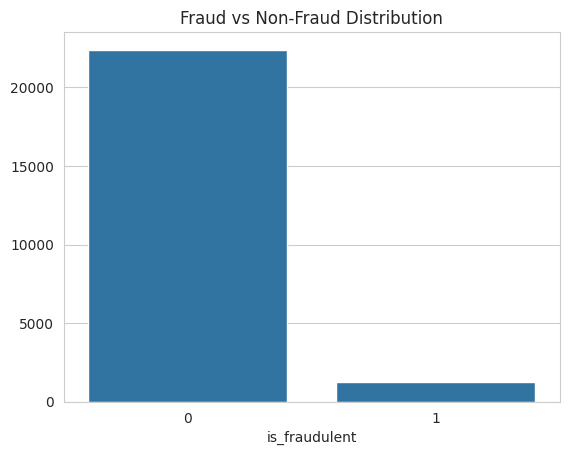

Fraud Ratio: 5.17051705170517%


In [13]:
# Visualize the distribution of the target variable
fraud_counts = df_eda['is_fraudulent'].value_counts()
print(fraud_counts)
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()
print(f"Fraud Ratio: {df_eda['is_fraudulent'].mean() * 100}%")

Insight: The dataset is highly imbalanced, with only 5.17% of transactions being fraudulent. This imbalance fundamentally changes how we must evaluate model performance. A standard approach will fail here; therefore, we have defined a strict metric strategy:

**Metrics We Will NOT Use**:

**Accuracy**: This is a deceptive metric for this dataset. A "dummy" model that predicts No Fraud for every single transaction would achieve 94.83% accuracy while catching zero fraud. It provides no value.
**ROC-AUC**: While popular, ROC-AUC is misleading for highly imbalanced data. It calculates the False Positive Rate based on the massive number of legitimate transactions (True Negatives). As a result, the ROC-AUC score can stay high (e.g., 0.98) even if the model is flagging thousands of false positives. It paints an overly optimistic picture of performance.


**Our Primary Optimization Metric**:

**PR-AUC (Precision-Recall Area Under Curve)**: We will use this as our primary metric for hyperparameter tuning.
Why? Unlike ROC-AUC, PR-AUC ignores True Negatives. It focuses exclusively on how well the model ranks the minority class (Fraud) against the noise. If the model generates false alarms, the PR-AUC score drops immediately. It is the most rigorous "truth-teller" for imbalanced datasets.


**Business Decision Metric**:

**F2-Score**: While we tune on PR-AUC, our final decision threshold will be selected to maximize the F2-Score. In fraud detection, a False Negative (missing a fraudster) is costlier than a False Positive (a manual review). The F2-Score weighs Recall higher than Precision, aligning the model with business reality.

*Note: In a real-world setting, this threshold is flexible. If stakeholders prefer to minimize customer friction (fewer false alarms), we would shift towards F1 or F0.5. If the cost of fraud is catastrophic, we would push further towards F2 or Recall. For this Ecommerce fraud detection project, we assume catching fraud is the priority and hence we will use the F2 Score for the final decision threshold.*

## Transaction Amount by Fraud Status

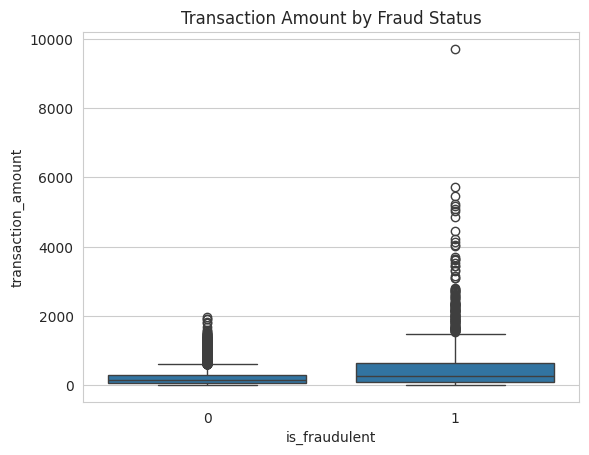

In [14]:
# Visualize transaction amounts for fraudulent vs non-fraudulent transactions
sns.boxplot(x='is_fraudulent', y='transaction_amount', data=df_eda)
plt.title("Transaction Amount by Fraud Status")
plt.show()

Insight: While the median transaction amount is slightly higher for fraudulent transactions, the most significant difference is in the variance and presence of high-value outliers. The fraudulent group has a much wider spread of transaction amounts and contains many more extreme high-value transactions. This suggests that Transaction Amount is a valuable feature, especially for identifying unusually large purchases.

## Distribution of Numeric Features

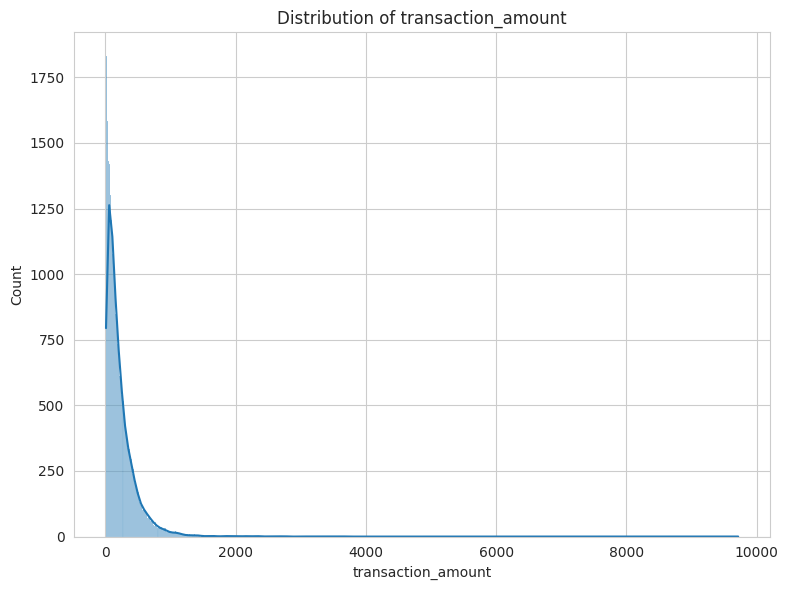

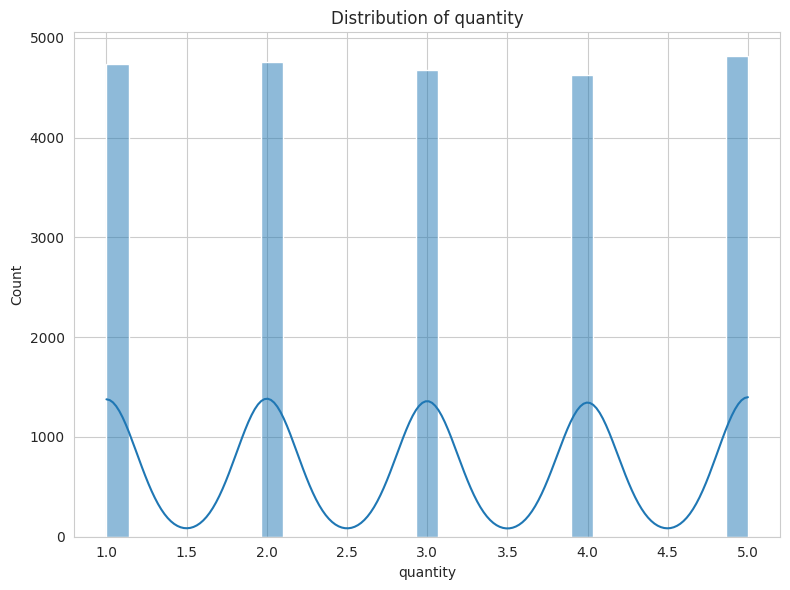

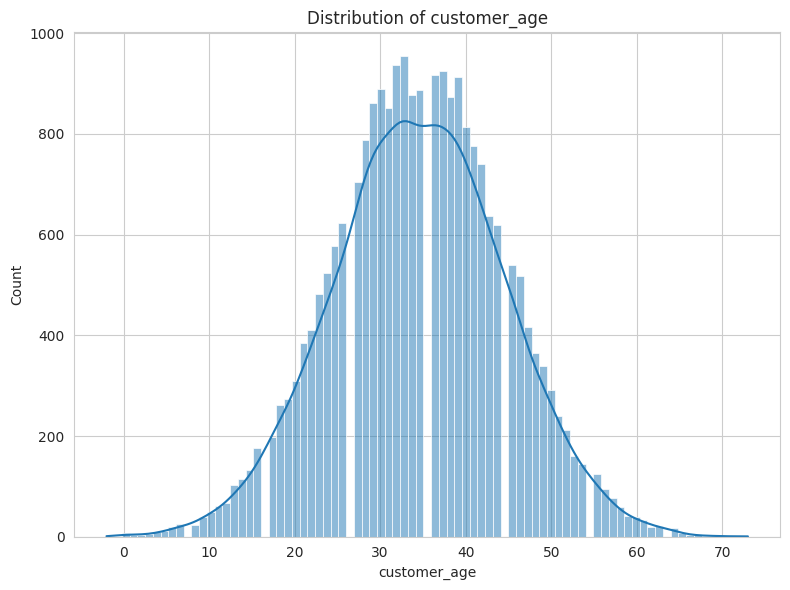

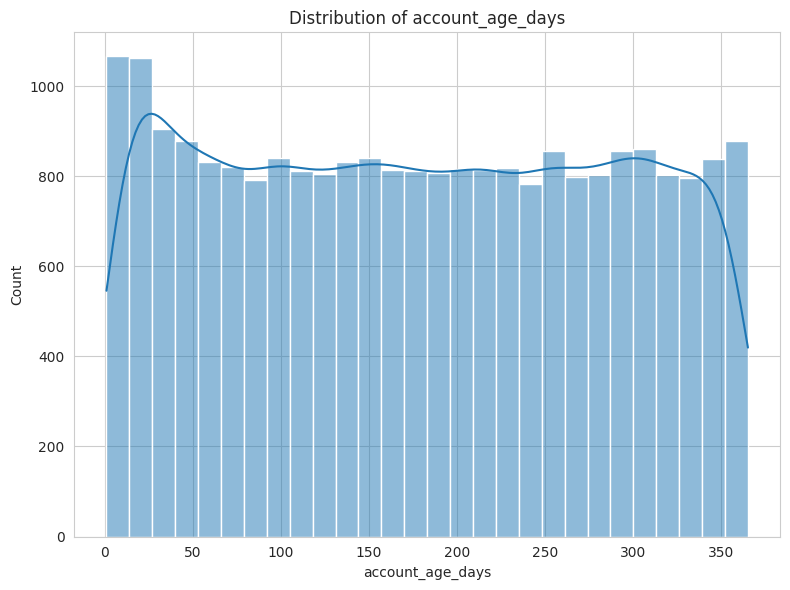

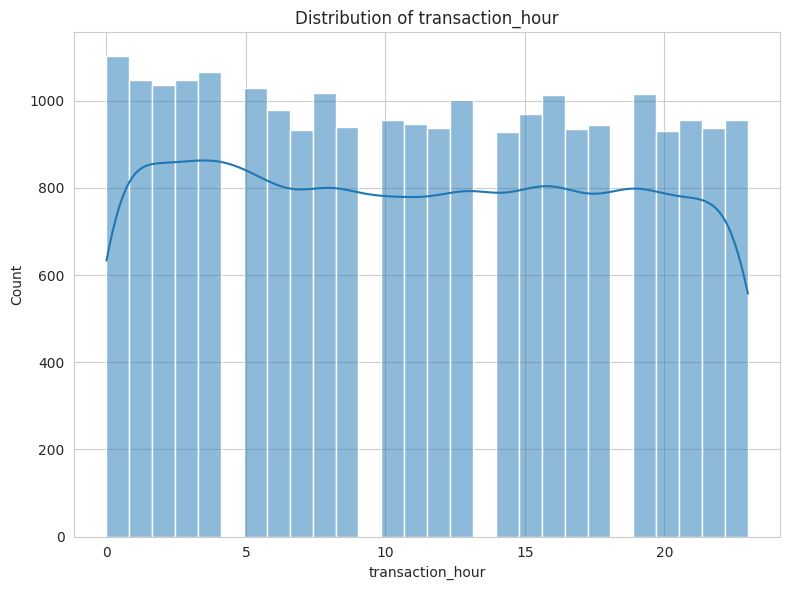

In [15]:
# Select numeric columns
numeric_cols = df_eda.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Plot distributions
for col in numeric_cols:
    if col == 'is_fraudulent':
        continue
    plt.figure(figsize=(8, 6))
    sns.histplot(df_eda[col], kde=True)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()


Insight: The transaction amounts are heavily right-skewed, with the vast majority of transactions being of low value. This is typical for e-commerce data. For some machine learning models (like linear regression or models that assume normality), applying a log transformation to this feature can improve performance.

## Analyzing Temporal Patterns

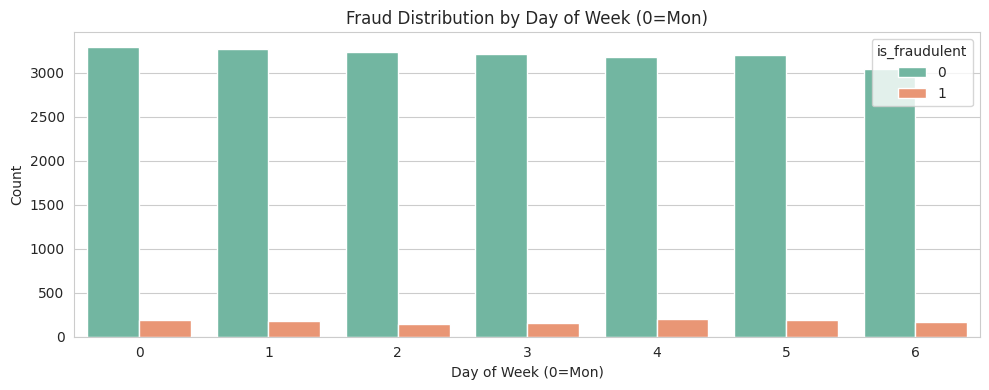

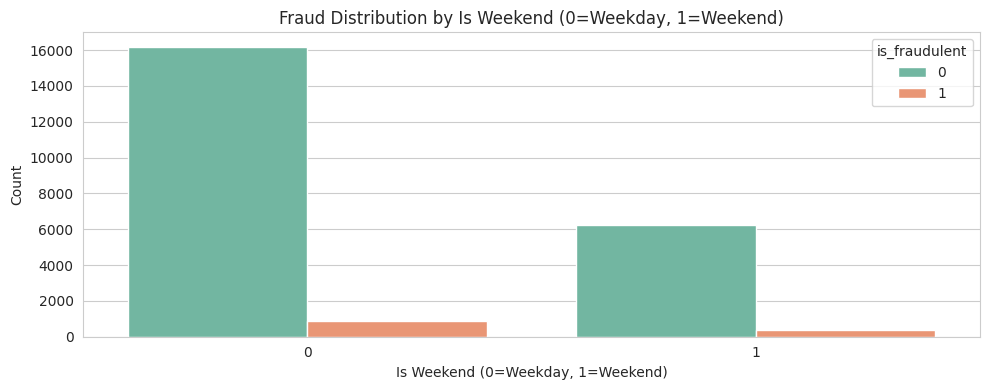

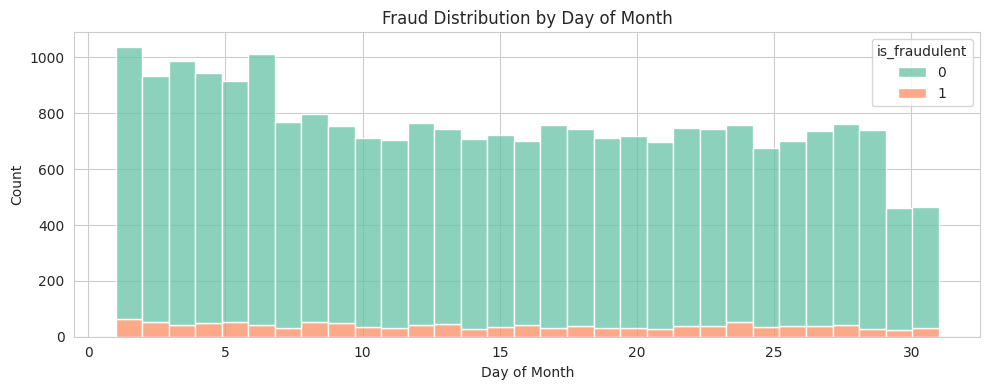

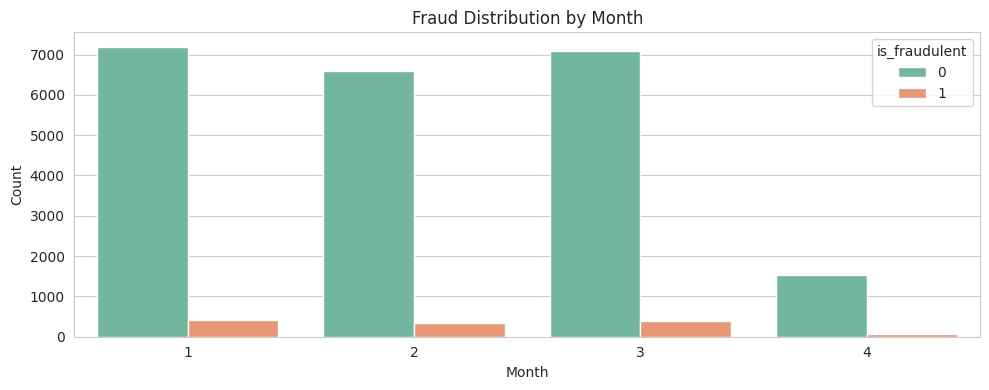

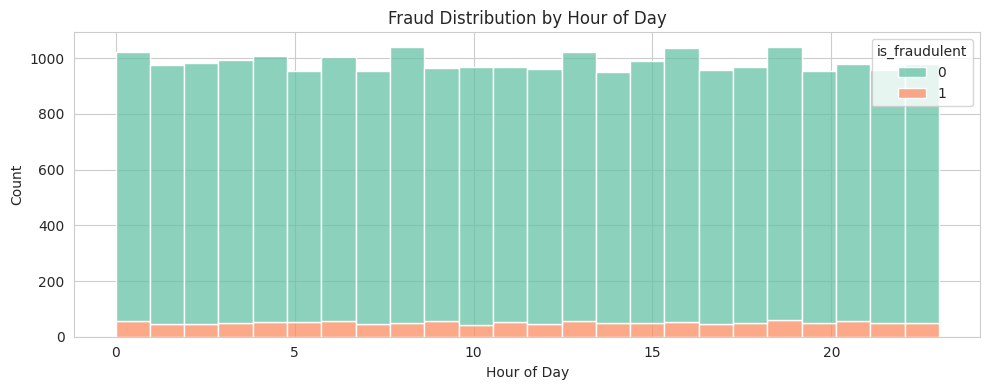

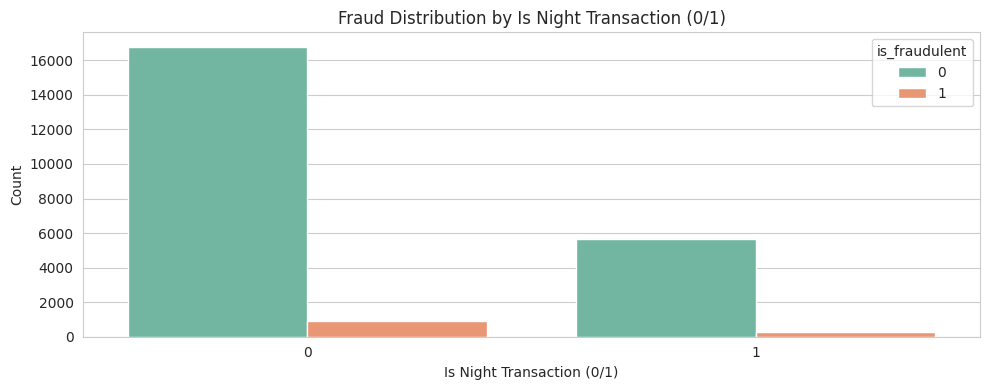


 Numerical Summary for day_of_week 
 day_of_week  fraud_rate  count  percentage
           0      0.0546   3482       14.73
           1      0.0508   3442       14.56
           2      0.0429   3378       14.29
           3      0.0453   3358       14.21
           4      0.0589   3380       14.30
           5      0.0564   3388       14.34
           6      0.0530   3206       13.57

 Numerical Summary for is_weekend 
 is_weekend  fraud_rate  count  percentage
          0      0.0505  17040        72.1
          1      0.0547   6594        27.9

 Numerical Summary for transaction_day 
 transaction_day  fraud_rate  count  percentage
               1      0.0597   1038        4.39
               2      0.0567    935        3.96
               3      0.0426    986        4.17
               4      0.0519    944        3.99
               5      0.0590    916        3.88
               6      0.0406   1011        4.28
               7      0.0403    770        3.26
               8     

In [16]:
def analyze_temporal_patterns(data, target_col='is_fraudulent'):
    """
    Extracts temporal features and produces 7 visualizations — one per feature.
    """

    # Ensure datetime
    data['transaction_date'] = pd.to_datetime(data['transaction_date'])

    # --- Extract Temporal Features ---
    data['day_of_week'] = data['transaction_date'].dt.weekday
    data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
    data['transaction_day'] = data['transaction_date'].dt.day
    data['transaction_month'] = data['transaction_date'].dt.month
    data['hour_of_day'] = data['transaction_date'].dt.hour
    data['is_night_transaction'] = data['hour_of_day'].isin([0,1,2,3,4,5]).astype(int)

    # Features to plot
    features = {
        "day_of_week": "Day of Week (0=Mon)",
        "is_weekend": "Is Weekend (0=Weekday, 1=Weekend)",
        "transaction_day": "Day of Month",
        "transaction_month": "Month",
        "hour_of_day": "Hour of Day",
        "is_night_transaction": "Is Night Transaction (0/1)"
    }

    # --- Plot each feature ---
    for col, title in features.items():
        plt.figure(figsize=(10,4))

        # Use histplot for features with many unique values
        if data[col].nunique() > 10:
            sns.histplot(data=data, x=col, hue='is_fraudulent',
                        multiple='stack', bins=data[col].nunique(), palette='Set2')
        else:
            sns.countplot(data=data, x=col, hue='is_fraudulent', palette='Set2')

        plt.title(f"Fraud Distribution by {title}")
        plt.xlabel(title)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

    # --- Numerical Summary Tables ---
    summary_tables = {}

    for col in features.keys():
        summary = (
            data
            .groupby(col)['is_fraudulent']
            .agg(
                fraud_rate='mean',
                count='count'
            )
            .reset_index()
        )
        summary['percentage'] = (summary['count'] / len(data) * 100).round(2)
        summary['fraud_rate'] = summary['fraud_rate'].round(4)

        summary_tables[col] = summary

        print("\n=====================================")
        print(f" Numerical Summary for {col} ")
        print("=====================================")
        print(summary.to_string(index=False))


analyze_temporal_patterns(df_eda, target_col='is_fraudulent')

Insight: Fraudulent transactions appear fairly evenly distributed across days, hours, and months, but several subtle temporal patterns do emerge.

Day of Week: Fraud rates fluctuate mildly, with slightly elevated levels on Thursdays (0.0589), Saturdays (0.0564), and Mondays (0.0546). However, the variation is small, indicating no strong weekday-specific fraud pattern.

Weekend vs Weekday: Weekends show a slightly higher fraud rate (0.0547 vs 0.0505), suggesting increased fraud activity but not a dramatic shift.

Day of Month: Certain dates—including the 1st, 3rd, and 6th—show moderately higher fraud rates. However, these spikes do not form a consistent pattern across months.

Month: Fraud is relatively stable across January–March (0.049–0.054). The lower fraud rate in April (0.0488) appears driven by a smaller sample size rather than true behavior.

Hour of Day: Fraud rates remain consistent across hours, with slightly higher activity around 0:00, 8:00, 13:00, 16:00 and 19:00 though differences are marginal.

Night vs Day: Night transactions have similar fraud rates to daytime transactions (0.0509 vs 0.0520), indicating no meaningful night-time fraud spike.

Overall Insight:
Temporal features show weak but measurable signals — none of the time-based variables appear strong standalone predictors, but their small variations (e.g., weekday effects, certain days of month, slight weekend lift) can still contribute incremental predictive value when combined with customer, transactional, or behavioral features in a machine learning model.

## Analyzing Categorical Features

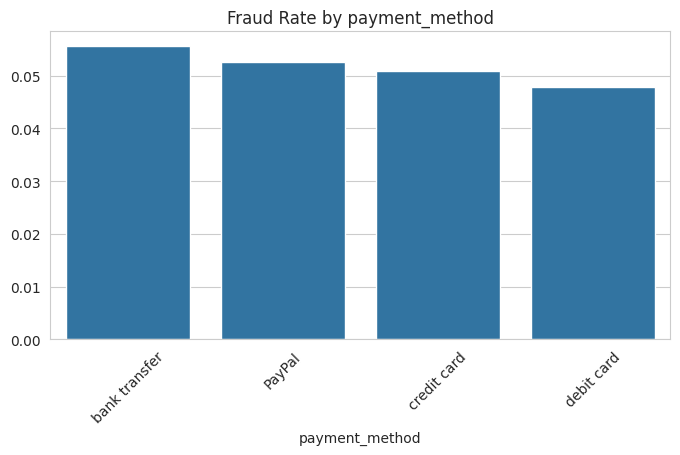

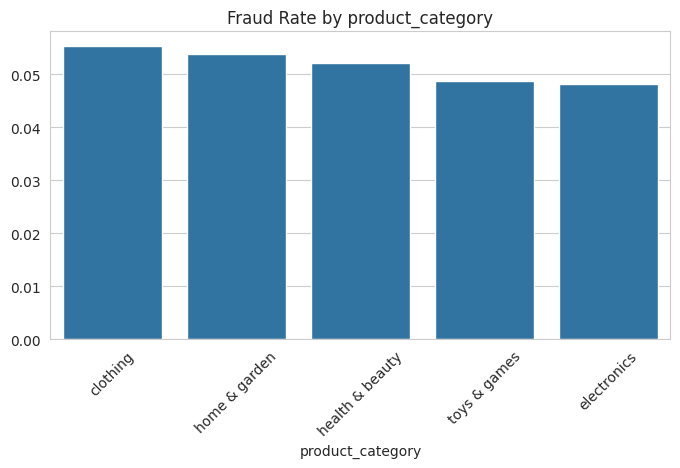

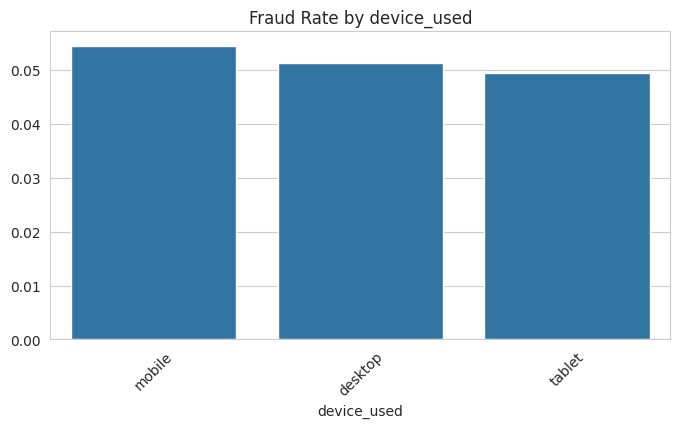

In [17]:
# Analyze fraud rates across categorical features
categorical_cols = ['payment_method', 'product_category', 'device_used']

for col in categorical_cols:
    fraud_rate = df_eda.groupby(col)['is_fraudulent'].mean().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(x=fraud_rate.index, y=fraud_rate.values)
    plt.title(f"Fraud Rate by {col}")
    plt.xticks(rotation=45)
    plt.show()

Insight: The fraud rate is remarkably consistent (around 5%) across all categories for these features. For example, using a 'bank transfer' isn't significantly more or less risky than using a 'credit card'. This means these features, in their current form, have low predictive power on their own. However, they could still be useful in combination with other features (e.g., a high-value 'electronics' purchase on a 'mobile' device).

## Analyzing Customer Demographics

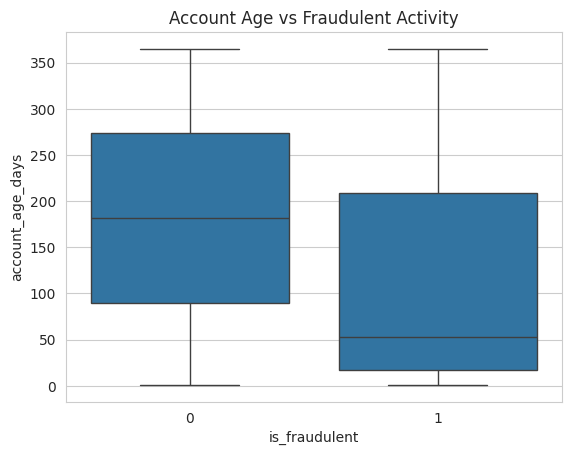

In [18]:
# Customer demographics analysis
sns.boxplot(x='is_fraudulent', y='account_age_days', data=df_eda)
plt.title("Account Age vs Fraudulent Activity")
plt.show()

Insight: This is a very strong signal. Fraudulent activity is heavily concentrated in newer accounts. The median account age for fraudulent transactions is significantly lower than for non-fraudulent ones. This is a classic fraud pattern: fraudsters create new accounts to burn before they get caught. account_age_days will be a crucial feature.

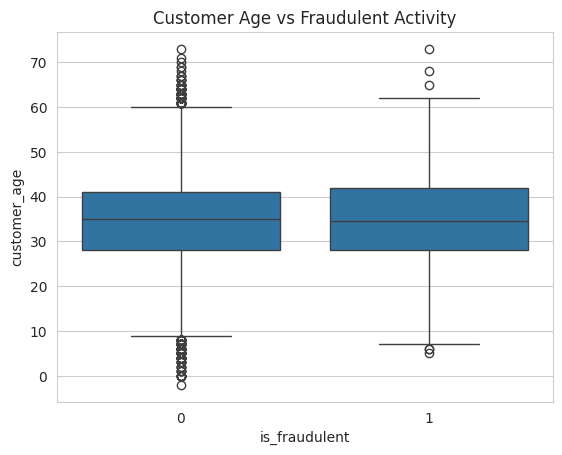

In [19]:
sns.boxplot(x='is_fraudulent', y='customer_age', data=df_eda)
plt.title("Customer Age vs Fraudulent Activity")
plt.show()

Insight: Unlike account age, the customer's actual age shows almost no difference between fraudulent and non-fraudulent transactions. The distributions are nearly identical. This feature is likely to have very low predictive power.

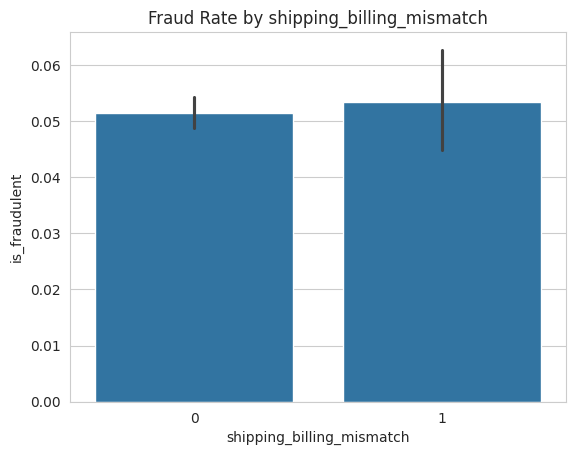

In [20]:
# Address mismatch analysis
df_eda['shipping_billing_mismatch'] = (df_eda['shipping_address'] != df_eda['billing_address']).astype(int)
sns.barplot(x='shipping_billing_mismatch', y='is_fraudulent', data=df_eda)
plt.title("Fraud Rate by shipping_billing_mismatch")
plt.show()

Insight: An address mismatch does not significantly increase the fraud rate in this dataset. This is somewhat surprising, as it's often a red flag. It could be that many legitimate customers (e.g., those sending gifts) have mismatches, diluting the signal from fraudsters.

## Correlation Between Numeric Features

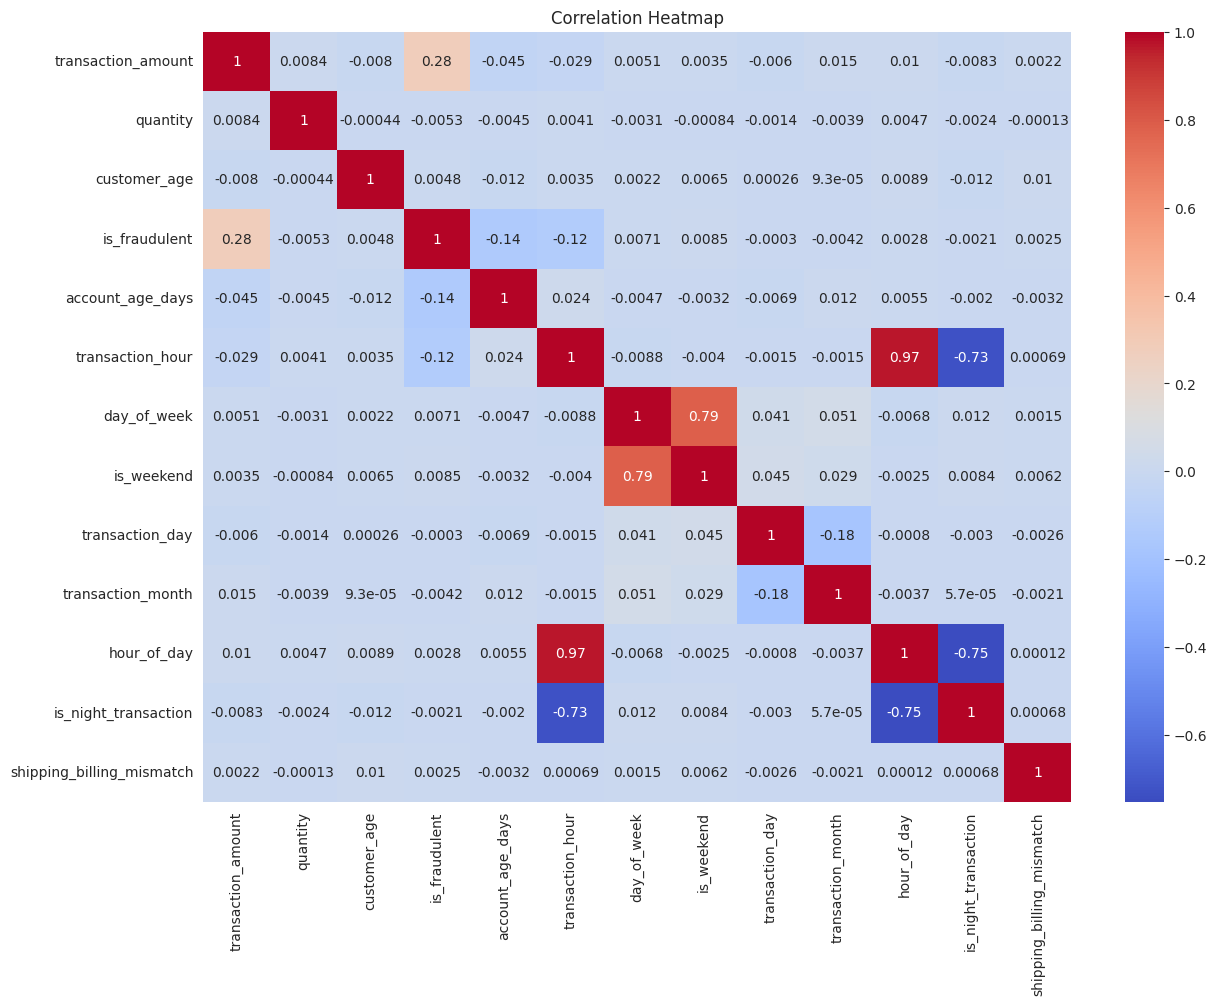

In [21]:
# Correlation analysis
numeric_cols = df_eda.select_dtypes(include=['int','float']).columns.tolist()
corr = df_eda[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Insight: The heatmap confirms the previous findings numerically. hour_of_day has the strongest positive linear correlation (0.28) with fraud, and account_age_days has the strongest negative correlation (-0.14) followed by transaction_hour (-0.12). The other numeric features have near-zero correlation, indicating little to no linear relationship with fraud.

## Importance of categorical variables with target variable

In [22]:
def categorical_target_association(df_eda, target_col):
    results = []

    # Select categorical columns (exclude ID-like ones)
    categorical_cols = df_eda.select_dtypes(include=['object', 'category']).columns
    print(categorical_cols)

    for col in categorical_cols:
        # Skip columns that are unique identifiers
        if df_eda[col].nunique() > 50:
            continue

        unique_vals = df_eda[col].nunique()
        target = df_eda[target_col]

        # Binary categorical → use t-test
        if unique_vals == 2:
            groups = []
            for val in df_eda[col].unique():
                groups.append(target[df_eda[col] == val])

            t_stat, p_val = ttest_ind(groups[0], groups[1], equal_var=False)
            test_type = 't-test'

        # Multi-category → use chi-squared test
        else:
            contingency = pd.crosstab(df_eda[col], target)
            chi2, p_val, dof, expected = chi2_contingency(contingency)
            test_type = 'chi-square'

        results.append({
            'Feature': col,
            'Unique Values': unique_vals,
            'Test': test_type,
            'p-value': p_val
        })

    results_df = pd.DataFrame(results)
    results_df['Significant (p<0.05)'] = results_df['p-value'] < 0.05
    return results_df.sort_values('p-value')

results = categorical_target_association(df_eda, 'is_fraudulent')
print(results)

Index(['transaction_id', 'customer_id', 'payment_method', 'product_category',
       'customer_location', 'device_used', 'ip_address', 'shipping_address',
       'billing_address'],
      dtype='object')
            Feature  Unique Values        Test   p-value  Significant (p<0.05)
0    payment_method              4  chi-square  0.284269                 False
2       device_used              3  chi-square  0.356638                 False
1  product_category              5  chi-square  0.444859                 False


Insight: The Chi Square analysis showed that there is no statistical significance between the categorical variables and target variable as all p-values are above 0.05. This indicates that these features alone do not strongly differentiate between fraud and legitimate transactions. There is a need to combine these categorical features with other features.

## Benford's Law Analysis


--- Benford's Law Analysis on 'Transaction Amount' ---
Displaying Benford's Law plot. Close the plot window to continue the script...


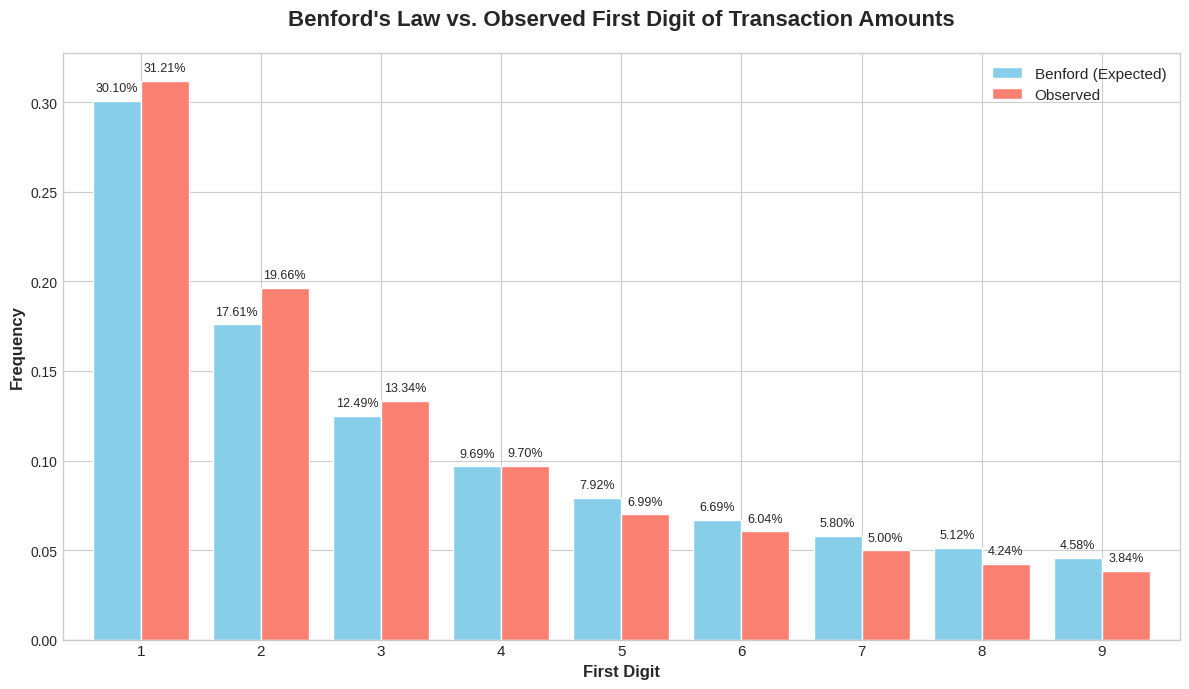

In [23]:
def benfords_law_analysis(data, column, title):
    """
    Performs Benford's Law analysis and displays the plot.
    The script will pause here until you close the plot window.
    """
    print(f"\n--- Benford's Law Analysis on '{title}' ---")

    # 1. Isolate the first digit
    first_digits = data[column][data[column] > 0].astype(str).str[0].astype(int)

    # 2. Calculate observed frequency
    observed_freq = first_digits.value_counts(normalize=True).sort_index()

    # 3. Calculate expected Benford frequency
    benford_digits = np.arange(1, 10)
    expected_freq = np.log10(1 + 1/benford_digits)

    # 4. Create a DataFrame for plotting
    analysis_df = pd.DataFrame({
        'Digit': benford_digits,
        'Benford (Expected)': expected_freq
    }).set_index('Digit')
    analysis_df = analysis_df.join(observed_freq.rename('Observed')).fillna(0)

    # 5. Generate and style the plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    analysis_df.plot(kind='bar', ax=ax, width=0.8, color=['skyblue', 'salmon'])

    ax.set_title("Benford's Law vs. Observed First Digit of Transaction Amounts", fontsize=16, pad=20, weight='bold')
    ax.set_xlabel("First Digit", fontsize=12, weight='bold')
    ax.set_ylabel("Frequency", fontsize=12, weight='bold')
    ax.tick_params(axis='x', rotation=0, labelsize=11)
    ax.legend(fontsize=11)

    # Add percentage labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=9)

    plt.tight_layout()

    # 6. Display the plot. The script will pause here.
    print("Displaying Benford's Law plot. Close the plot window to continue the script...")
    plt.show()

# Call the function to display the plot
benfords_law_analysis(df_eda, 'transaction_amount', 'Transaction Amount')

Insight: Transaction amount roughly follows Benford’s Law.

# More indepth EDA

## Are high-value fraudulent transactions more common in specific product categories?

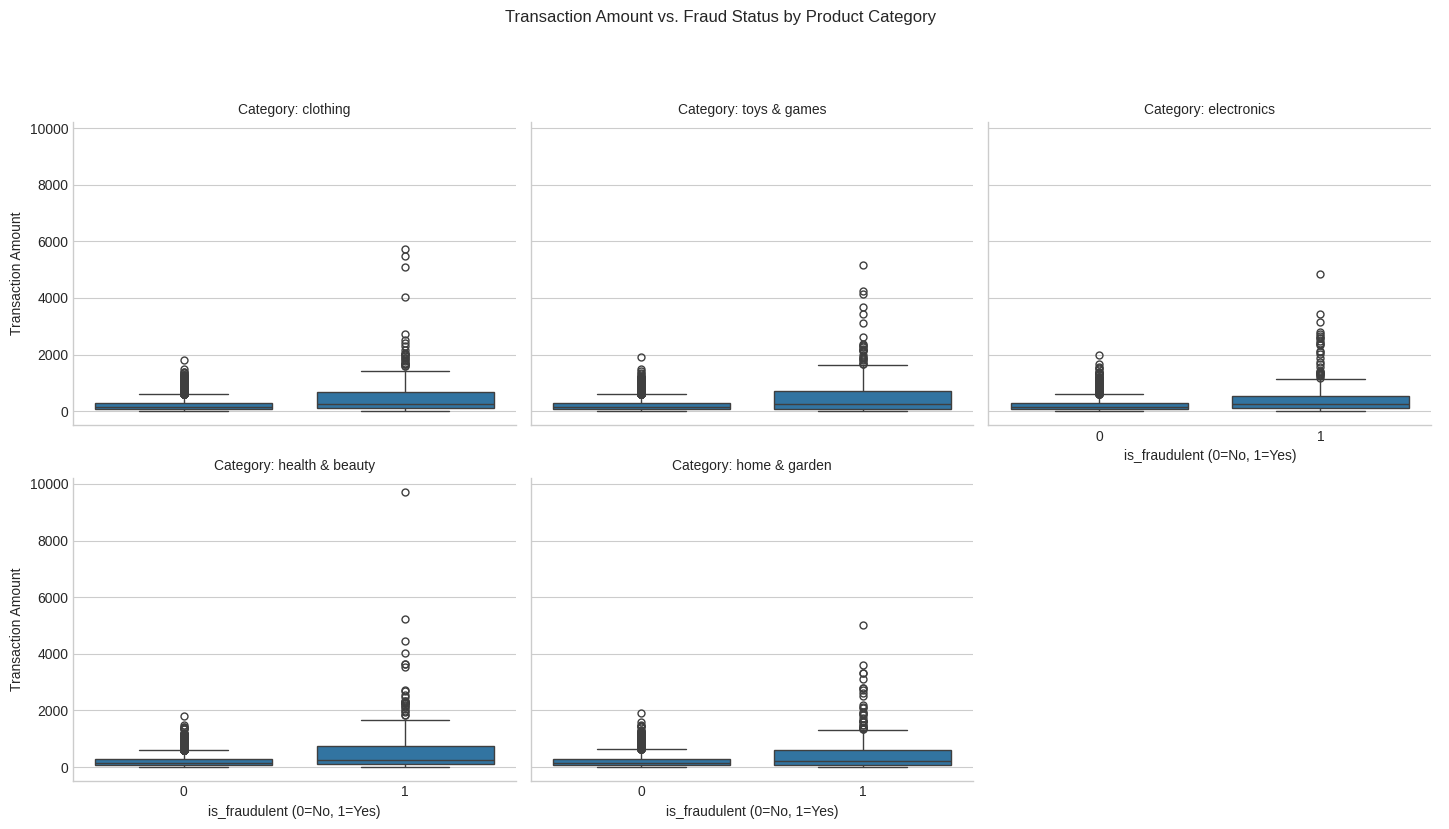

In [24]:
# Create a faceted boxplot
g = sns.catplot(
    x='is_fraudulent',
    y='transaction_amount',
    col='product_category',
    data=df_eda,
    kind='box',
    col_wrap=3, # Wraps the plots into 3 columns
    height=4,
    aspect=1.2
)

# Set titles and labels for clarity
g.fig.suptitle('Transaction Amount vs. Fraud Status by Product Category', y=1.03)
g.set_axis_labels("is_fraudulent (0=No, 1=Yes)", "Transaction Amount")
g.set_titles("Category: {col_name}")

# To prevent clipping of the suptitle
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Insight: The general pattern holds true across all categories: fraudulent transactions (1) have a higher median amount and significantly more high-value outliers than non-fraudulent transactions (0).

## How many unique IPs/Addresses does a customer use? (Fraud rings)

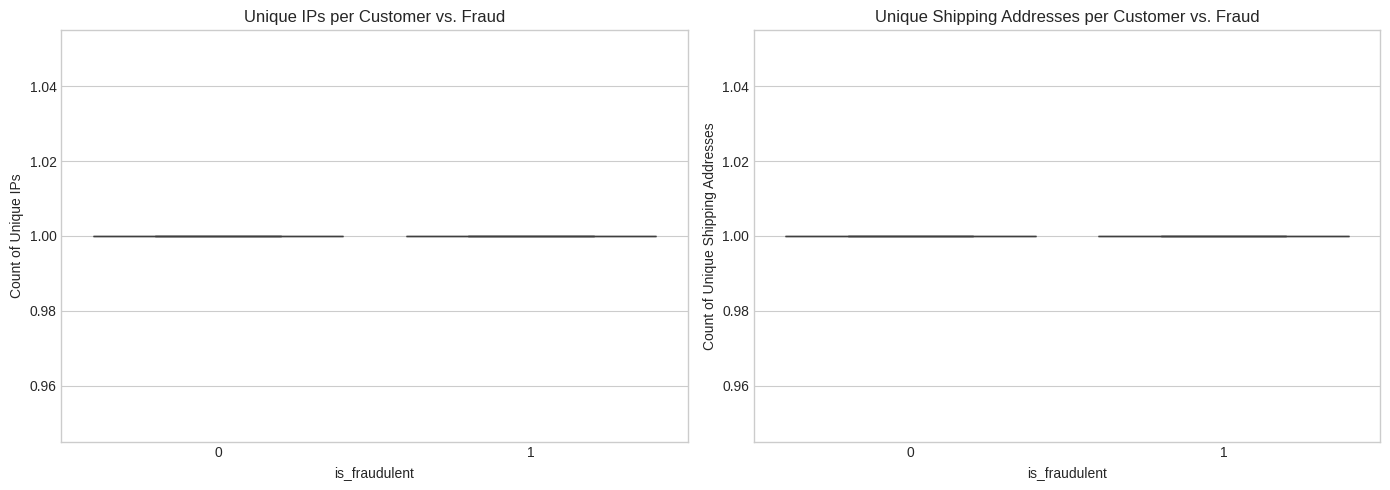

In [25]:
# Group by Customer ID and count unique IPs and Shipping Addresses
customer_behavior = df_eda.groupby('customer_id').agg(
    unique_ips_per_customer=pd.NamedAgg(column='ip_address', aggfunc='nunique'),
    unique_shipping_add_per_customer=pd.NamedAgg(column='shipping_address', aggfunc='nunique')
).reset_index()

# Merge this back into the main dataframe
df_eda = pd.merge(df_eda, customer_behavior, on='customer_id', how='left')

# Visualize the findings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x='is_fraudulent', y='unique_ips_per_customer', data=df_eda, ax=axes[0])
axes[0].set_title('Unique IPs per Customer vs. Fraud')
axes[0].set_ylabel('Count of Unique IPs')

sns.boxplot(x='is_fraudulent', y='unique_shipping_add_per_customer', data=df_eda, ax=axes[1])
axes[1].set_title('Unique Shipping Addresses per Customer vs. Fraud')
axes[1].set_ylabel('Count of Unique Shipping Addresses')

plt.tight_layout()
plt.show()

Insight: Every customer has exactly one unique IP and one unique shipping address, and consequently, no IP addresses are ever shared.
This is completely unrealistic and is the strongest evidence yet that this is a heavily sanitized or synthetic dataset. In the real world, customers use multiple devices (phone, work PC, home laptop) and send gifts to different addresses. Fraud rings are often identified by many accounts using the same IP.

## How many distinct values are there for each object column

In [26]:
# Count number of distinct values for each object column
distinct_df = df.select_dtypes(include='object').nunique().reset_index()
distinct_df.columns = ['column', 'distinct_count']
print(distinct_df)
print('\ndf_eda shape:')
print(df_eda.shape)


              column  distinct_count
0     transaction_id           23634
1        customer_id           23634
2     payment_method               4
3   product_category               5
4  customer_location           14868
5        device_used               3
6         ip_address           23634
7   shipping_address           23634
8    billing_address           23634

df_eda shape:
(23634, 25)


Insight: Some columns such as transaction_id, customer_id, ip_address, shipping_address, billing_address may not be useful alone as they have the same cardinality as the shape of df

# Feature Engineering

In [27]:
# --- FEATURE ENGINEERING ---
df['hour_of_day'] = df['transaction_date'].dt.hour
df['day_of_week'] = df['transaction_date'].dt.dayofweek
df['is_night_transaction'] = df['hour_of_day'].isin([0, 1, 2, 3, 4, 5]).astype(int)
df['shipping_billing_mismatch'] = (df['shipping_address'] != df['billing_address']).astype(int)

df['amount_to_account_age_ratio'] = df['transaction_amount'] / (df['account_age_days'] + 1)

# --- DATA PREPARATION FOR MODELING ---
features_to_drop = ['transaction_id', 'customer_id', 'transaction_date', 'shipping_address', 'billing_address', 'is_fraudulent',
                      'customer_location', 'ip_address'] # Drop helper column
X = df.drop(columns=features_to_drop)
y = df['is_fraudulent']
categorical_features = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
numerical_features = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# --- Log skewed numerical features for Logistic Regression ---
# Create a copy of X_train and X_test for Logistic Regression
X_train_lr, X_test_lr = X_train.copy(), X_test.copy()

# Log-transform transaction_amount
X_train_lr['transaction_amount'] = np.log1p(X_train_lr['transaction_amount'])
X_test_lr['transaction_amount'] = np.log1p(X_test_lr['transaction_amount'])
scaler_lr = StandardScaler()
X_train_lr[numerical_features] = scaler_lr.fit_transform(X_train_lr[numerical_features])
X_test_lr[numerical_features] = scaler_lr.transform(X_test_lr[numerical_features])

print(X_train.shape, X_test.shape)

(18907, 19) (4727, 19)


In [28]:
X_test_lr.columns

Index(['transaction_amount', 'quantity', 'customer_age', 'account_age_days',
       'transaction_hour', 'hour_of_day', 'day_of_week',
       'is_night_transaction', 'shipping_billing_mismatch',
       'amount_to_account_age_ratio', 'payment_method_bank transfer',
       'payment_method_credit card', 'payment_method_debit card',
       'product_category_electronics', 'product_category_health & beauty',
       'product_category_home & garden', 'product_category_toys & games',
       'device_used_mobile', 'device_used_tablet'],
      dtype='object')

# Model Training

## Helper Functions

In [29]:
def evaluate_model(model, X_test, y_test, y_pred=None, y_proba=None, top_n_features=20, target_names=['Not Fraud', 'Fraud']):
    """
    General model evaluation: metrics, confusion matrix, and feature importance.

    Args:
        model : trained classifier
        X_test (pd.DataFrame): test features
        y_test (array-like): true labels
        y_pred (array-like, optional): predicted labels; if None, uses model.predict(X_test)
        y_proba (array-like, optional): predicted probabilities for positive class; if None, tries model.predict_proba
        top_n_features (int): number of top features to show in importance plot
        target_names (list): names for classification report & confusion matrix
    """
    # --- Predictions ---
    if y_pred is None:
        y_pred = model.predict(X_test)

    if y_proba is None:
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
        except:
            y_proba = None

    # --- Metrics ---
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=target_names))

    if y_proba is not None:
        print("\n--- ROC AUC / AUPRC ---")
        print(f"AUPRC Score: {average_precision_score(y_test, y_proba):.4f}")
        print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # --- Feature Importance ---
    importance = None
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = model.coef_[0] if model.coef_.ndim > 1 else model.coef_

    if importance is not None:
        feature_importance_df = pd.DataFrame({
            'feature': X_test.columns,
            'importance': importance
        }).sort_values('importance', ascending=False).head(top_n_features)

        top_features = feature_importance_df['feature'].tolist()    # For potential further analysis
        plt.figure(figsize=(10,8))
        sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
        plt.title(f'Top {top_n_features} Feature Importances')
        plt.show()
        return top_features

## Logistic Regression

In [30]:
# --- HYPERPARAMETER TUNING WITH OPTUNA ---
def objective(trial, X, y, random_seed):
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])

    solver = 'liblinear'

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        class_weight=class_weight,
        max_iter=2000,
        random_state=random_seed
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

    score = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring='average_precision',
        n_jobs=-1
    )

    return score.mean()

print("Starting Hyperparameter Tuning (Optuna TPE Sampler)...")
print("Tuning 'C', 'penalty', and 'class_weight'.")

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))

study.optimize(
    lambda trial: objective(trial, X_train_lr, y_train, RANDOM_STATE),

    n_trials=50,
    show_progress_bar=True
)
print("Tuning complete")

[I 2025-11-20 12:12:47,203] A new study created in memory with name: no-name-cac5f620-395e-46c8-92f6-a4075d0b367d


Starting Hyperparameter Tuning (Optuna TPE Sampler)...
Tuning 'C', 'penalty', and 'class_weight'.


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-20 12:12:51,273] Trial 0 finished with value: 0.47389320980789124 and parameters: {'C': 0.017670169402947963, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.47389320980789124.
[I 2025-11-20 12:12:51,570] Trial 1 finished with value: 0.2557067080489901 and parameters: {'C': 0.0008629132190071859, 'penalty': 'l2', 'class_weight': None}. Best is trial 0 with value: 0.47389320980789124.
[I 2025-11-20 12:12:51,813] Trial 2 finished with value: 0.051726863323827796 and parameters: {'C': 0.00013289448722869195, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.47389320980789124.
[I 2025-11-20 12:12:52,261] Trial 3 finished with value: 0.36527669107373073 and parameters: {'C': 0.0012601639723276807, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.47389320980789124.
[I 2025-11-20 12:12:52,723] Trial 4 finished with value: 0.5301826879047009 and parameters: {'C': 0.4689400963537689, 'penalty': 'l2', 'cl

In [31]:
# Retrieve and display the best parameters and score
best_params = study.best_params
best_pr_auc = study.best_value

best_model_lr = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],

    class_weight=best_params['class_weight'],

    solver='liblinear',
    max_iter=2000,
    random_state=RANDOM_STATE
)

best_model_lr.fit(X_train_lr, y_train)

print("OPTUNA TUNING RESULTS")
print(f"BEST PARAMETERS FOUND: {best_params}")
print(f"BEST PR AUC SCORE (from Cross-Validation): {best_pr_auc:.4f}")

OPTUNA TUNING RESULTS
BEST PARAMETERS FOUND: {'C': 37.91498733978862, 'penalty': 'l1', 'class_weight': None}
BEST PR AUC SCORE (from Cross-Validation): 0.5382



--- Classification Report ---
              precision    recall  f1-score   support

   Not Fraud       0.97      1.00      0.98      4483
       Fraud       0.99      0.35      0.52       244

    accuracy                           0.97      4727
   macro avg       0.98      0.67      0.75      4727
weighted avg       0.97      0.97      0.96      4727


--- ROC AUC / AUPRC ---
AUPRC Score: 0.5504
ROC AUC Score: 0.8100


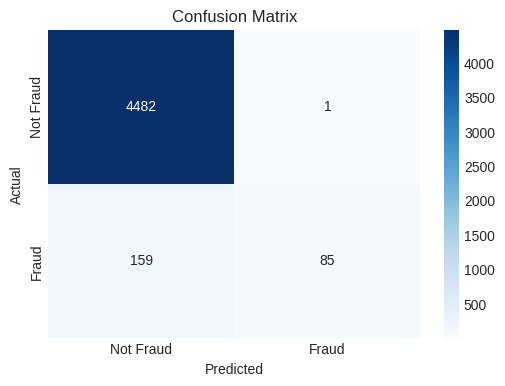

/tmp/ipython-input-2337059373.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


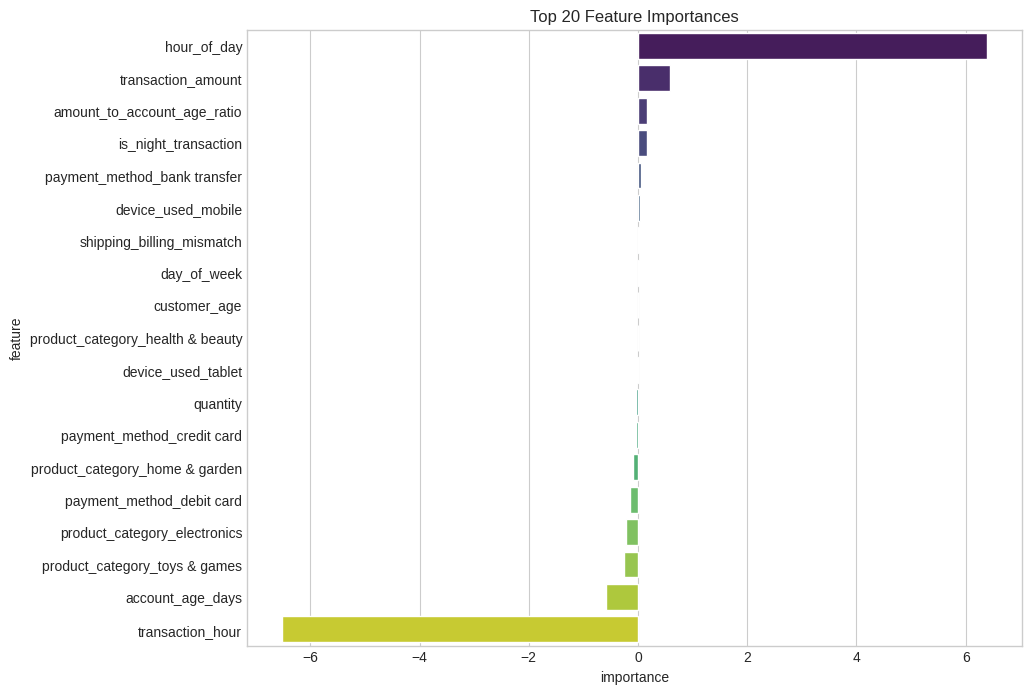

In [32]:
# --- EVALUATE THE MODEL ---
y_pred_lr = best_model_lr.predict(X_test_lr)
y_proba_lr = best_model_lr.predict_proba(X_test_lr)[:, 1]
top_features_lr = evaluate_model(best_model_lr, X_test_lr, y_test, y_pred=y_pred_lr, y_proba=y_proba_lr)

## XGBoost

In [33]:
# --- XGBOOST HYPERPARAMETER TUNING WITH OPTUNA ---
def objective(trial):
    scale_pos_weight = y_train.value_counts().get(0, 1) / y_train.value_counts().get(1, 1)

    params = {
        'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'random_state': RANDOM_STATE,
        'scale_pos_weight': scale_pos_weight,
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    # ---- K-FOLD ----
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(X_tr, y_tr, verbose=False)

        y_prob = model.predict_proba(X_val)[:, 1]

        # Evaluate PR-AUC (best for imbalanced fraud data)
        cv_scores.append(average_precision_score(y_val, y_prob))

    # Return mean CV score
    return np.mean(cv_scores)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=50) # Run 50 trials to find the best params

[I 2025-11-20 12:14:07,361] A new study created in memory with name: no-name-fbcec971-233d-45cc-88ce-50bb1fcdf335
[I 2025-11-20 12:14:10,459] Trial 0 finished with value: 0.5649130467756722 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1}. Best is trial 0 with value: 0.5649130467756722.
[I 2025-11-20 12:14:15,141] Trial 1 finished with value: 0.5606857853245198 and parameters: {'n_estimators': 893, 'max_depth': 8, 'learning_rate': 0.21534104756085318, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'gamma': 4.162213204002109, 'min_child_weight': 3}. Best is trial 0 with value: 0.5649130467756722.
[I 2025-11-20 12:14:19,329] Trial 2 finished with value: 0.5713064876727849 and parameters: {'n_estimators': 345, 'max_depth': 5, 'learning_rate': 0.09823025045826593, 'subsample': 0.8099025726528951, 'c

In [34]:
# Retrieve and display the best parameters and score
best_params = study.best_params
best_pr_auc = study.best_value

scale_pos_weight = y_train.value_counts().get(0, 1) / y_train.value_counts().get(1, 1)
best_model_xgb = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='aucpr', scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE, **best_params
)
best_model_xgb.fit(X_train, y_train)

print(f"BEST PARAMETERS FOUND: {best_params}")
print(f"BEST PR AUC SCORE (from Cross-Validation): {best_pr_auc:.4f}")

# Create training predictions for possible stacking
y_proba_xgb_train = best_model_xgb.predict_proba(X_train)[:, 1]

BEST PARAMETERS FOUND: {'n_estimators': 241, 'max_depth': 4, 'learning_rate': 0.017555192584768956, 'subsample': 0.7305588196481453, 'colsample_bytree': 0.708842105702502, 'gamma': 1.2187003789774784, 'min_child_weight': 8}
BEST PR AUC SCORE (from Cross-Validation): 0.5853



--- Classification Report ---
              precision    recall  f1-score   support

   Not Fraud       0.98      0.90      0.94      4483
       Fraud       0.27      0.72      0.40       244

    accuracy                           0.89      4727
   macro avg       0.63      0.81      0.67      4727
weighted avg       0.95      0.89      0.91      4727


--- ROC AUC / AUPRC ---
AUPRC Score: 0.5946
ROC AUC Score: 0.8544


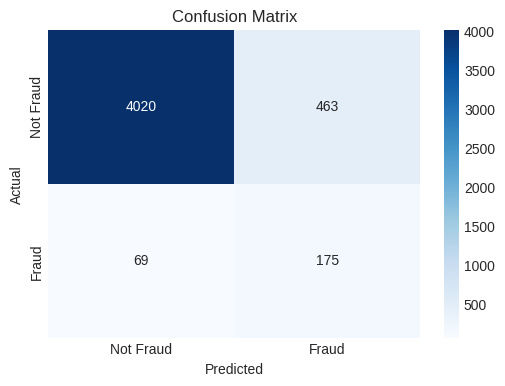

/tmp/ipython-input-2337059373.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


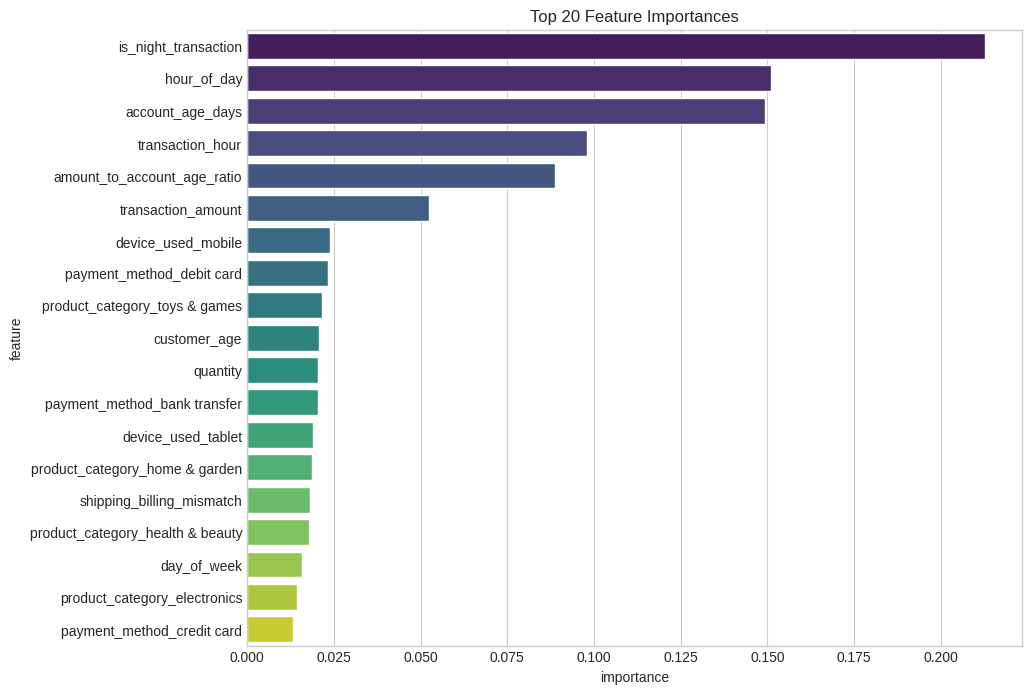

In [35]:
# --- EVALUATE THE MODEL ---
y_pred_xgb = best_model_xgb.predict(X_test)
y_proba_xgb = best_model_xgb.predict_proba(X_test)[:, 1]
top_features_xgb = evaluate_model(best_model_xgb, X_test, y_test, y_pred_xgb, y_proba_xgb)

## LightGBM

In [36]:
# --- LGB HYPERPARAMETER TUNING WITH OPTUNA ---
def objective(trial):
    scale_pos_weight = y_train.value_counts().get(0, 1) / y_train.value_counts().get(1, 1)

    params = {
        'objective': 'binary',
        'metric': 'average_precision',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': RANDOM_STATE,
        'scale_pos_weight': scale_pos_weight,

        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),

        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),

        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_tr, y_tr)
        y_prob = model.predict_proba(X_val)[:, 1]

        score = average_precision_score(y_val, y_prob)
        cv_scores.append(score)

    return np.mean(cv_scores)

print("Starting LightGBM Hyperparameter Tuning (Custom K-Fold)...")
study_lgbm = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study_lgbm.optimize(objective, n_trials=50)

[I 2025-11-20 12:16:56,522] A new study created in memory with name: no-name-d71c6957-a89d-4d29-a347-98dee9f91b00


Starting LightGBM Hyperparameter Tuning (Custom K-Fold)...


[I 2025-11-20 12:17:00,336] Trial 0 finished with value: 0.5435805002327199 and parameters: {'n_estimators': 500, 'learning_rate': 0.28570714885887566, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.5435805002327199.
[I 2025-11-20 12:17:17,261] Trial 1 finished with value: 0.5709444897336864 and parameters: {'n_estimators': 767, 'learning_rate': 0.01596950334578271, 'num_leaves': 147, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: 0.5709444897336864.
[I 2025-11-20 12:17:21,695] Trial 2 finished with value: 0.565713026917514 and parameters: {'n_estimators': 545, 'learning_rate': 0.09445645065743215, 'num_leaves': 100, 'max_depth': 4, 'min_c

In [37]:
# Retrieve and display the best parameters and score
best_params = study_lgbm.best_params
best_pr_auc = study_lgbm.best_value

scale_pos_weight = y_train.value_counts().get(0, 1) / y_train.value_counts().get(1, 1)

best_model_lgbm = lgb.LGBMClassifier(
    objective='binary',
    metric='average_precision',
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    verbosity=-1,
    **best_params
)

best_model_lgbm.fit(X_train, y_train)

print(f"BEST PARAMETERS FOUND: {best_params}")
print(f"BEST PR-AUC SCORE (from Cross-Validation): {best_pr_auc:.4f}")

# Create training predictions for possible stacking
y_proba_lgbm_train = best_model_lgbm.predict_proba(X_train)[:, 1]

BEST PARAMETERS FOUND: {'n_estimators': 802, 'learning_rate': 0.028241634086464143, 'num_leaves': 89, 'max_depth': 3, 'min_child_samples': 40, 'subsample': 0.8097305089787146, 'colsample_bytree': 0.7948760429106307, 'reg_alpha': 5.365082934808585e-06, 'reg_lambda': 0.4756929471613446}
BEST PR-AUC SCORE (from Cross-Validation): 0.5864



--- Classification Report ---
              precision    recall  f1-score   support

   Not Fraud       0.98      0.90      0.94      4483
       Fraud       0.27      0.69      0.39       244

    accuracy                           0.89      4727
   macro avg       0.63      0.79      0.67      4727
weighted avg       0.95      0.89      0.91      4727


--- ROC AUC / AUPRC ---
AUPRC Score: 0.5998
ROC AUC Score: 0.8485


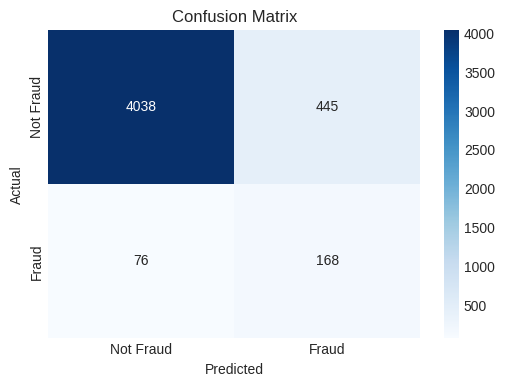

/tmp/ipython-input-2337059373.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


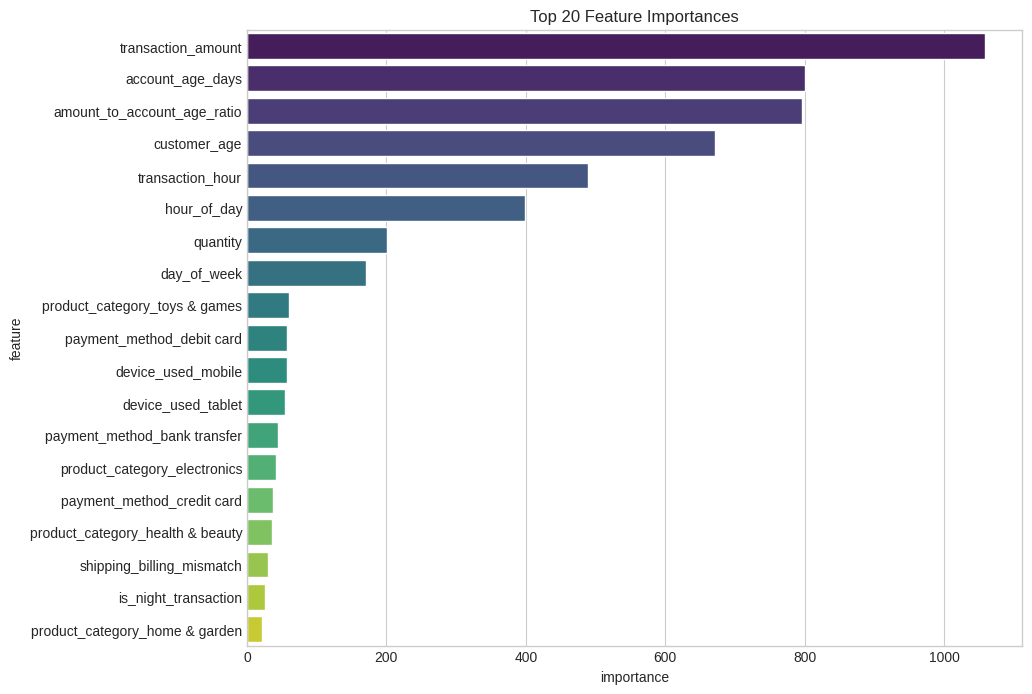

In [38]:
# --- EVALUATE THE MODEL ---
y_pred_lgbm = best_model_lgbm.predict(X_test)
y_proba_lgbm = best_model_lgbm.predict_proba(X_test)[:, 1]

top_features_lgbm = evaluate_model(best_model_lgbm, X_test, y_test, y_pred_lgbm, y_proba_lgbm)

## Unsupervised Learning: Isolation Forest

In [39]:
# --- Isolation Forest HYPERPARAMETER TUNING WITH OPTUNA (PR-AUC) ---
def objective(trial, X, y, random_seed):
    n_estimators = trial.suggest_int('n_estimators', 100, 600)
    # 'auto' is usually best for contamination when looking at scores,
    # but we can still tune specific percentages to see if it shifts the decision boundary usefuly.
    contamination = trial.suggest_float('contamination', 0.001, 0.05, log=True)
    max_samples = trial.suggest_categorical('max_samples', ['auto', 0.5, 0.75, 1.0])
    max_features = trial.suggest_float('max_features', 0.5, 1.0)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

    scores = []

    for train_idx, val_idx in cv.split(X, y):
        X_tr = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        model = IsolationForest(
            n_estimators=n_estimators,
            max_samples=max_samples,
            contamination=contamination,
            max_features=max_features,
            random_state=random_seed,
            n_jobs=-1
        )

        model.fit(X_tr)

        # Scikit-Learn Logic: Lower score = More Abnormal
        raw_scores = model.decision_function(X_val)

        # We want Higher score = More Abnormal (Fraud)
        anomaly_scores = -raw_scores

        score = average_precision_score(y_val, anomaly_scores)
        scores.append(score)

    return np.mean(scores)

print("Starting Isolation Forest Hyperparameter Tuning (Optuna TPE Sampler)...")
print("Tuning based on PR-AUC (Average Precision).")

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(
    lambda trial: objective(trial, X_train, y_train, RANDOM_STATE),
    n_trials=50,
    show_progress_bar=True
)

print("Tuning complete.")

[I 2025-11-20 12:22:22,045] A new study created in memory with name: no-name-e2c2b00a-13bf-4e51-bc3a-f4243cc0596d


Starting Isolation Forest Hyperparameter Tuning (Optuna TPE Sampler)...
Tuning based on PR-AUC (Average Precision).


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-20 12:22:27,665] Trial 0 finished with value: 0.2000393035011853 and parameters: {'n_estimators': 287, 'contamination': 0.04123206532618727, 'max_samples': 'auto', 'max_features': 0.5290418060840998}. Best is trial 0 with value: 0.2000393035011853.
[I 2025-11-20 12:22:50,790] Trial 1 finished with value: 0.2292886347990733 and parameters: {'n_estimators': 533, 'contamination': 0.010502105436744277, 'max_samples': 0.75, 'max_features': 0.6061695553391381}. Best is trial 1 with value: 0.2292886347990733.
[I 2025-11-20 12:22:57,311] Trial 2 finished with value: 0.21218104111434535 and parameters: {'n_estimators': 191, 'contamination': 0.002049268011541736, 'max_samples': 0.5, 'max_features': 0.8059264473611898}. Best is trial 1 with value: 0.2292886347990733.
[I 2025-11-20 12:23:05,203] Trial 3 finished with value: 0.2247723383091782 and parameters: {'n_estimators': 169, 'contamination': 0.0031357757322577457, 'max_samples': 0.75, 'max_features': 0.7571172192068059}. Best is tr

In [40]:
# Retrieve and display the best parameters and score
best_params = study.best_params
best_pr_auc = study.best_value

best_model_if = IsolationForest(
    n_estimators=best_params['n_estimators'],
    max_samples=best_params['max_samples'],
    contamination=best_params['contamination'],
    max_features=best_params['max_features'],
    random_state=RANDOM_STATE,
    n_jobs=-1
)
best_model_if.fit(X_train)

print("OPTUNA TUNING RESULTS (Isolation Forest)")
print(f"BEST PARAMETERS FOUND: {best_params}")
print(f"BEST PR-AUC SCORE (from Cross-Validation): {best_pr_auc:.4f}")

OPTUNA TUNING RESULTS (Isolation Forest)
BEST PARAMETERS FOUND: {'n_estimators': 554, 'contamination': 0.010832197063605093, 'max_samples': 1.0, 'max_features': 0.5225111560531286}
BEST PR-AUC SCORE (from Cross-Validation): 0.2377



--- Classification Report ---
              precision    recall  f1-score   support

   Not Fraud       0.95      1.00      0.97      4483
       Fraud       0.63      0.14      0.22       244

    accuracy                           0.95      4727
   macro avg       0.79      0.57      0.60      4727
weighted avg       0.94      0.95      0.94      4727


--- ROC AUC / AUPRC ---
AUPRC Score: 0.2436
ROC AUC Score: 0.7168


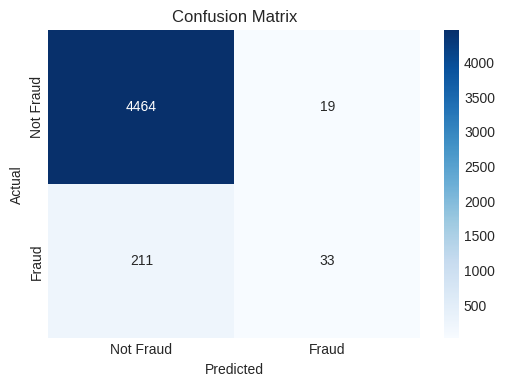

In [41]:
# --- EVALUATE THE MODEL ---
y_pred_raw = best_model_if.predict(X_test)
y_pred_if = np.where(y_pred_raw == -1, 1, 0) # Convert -1 (Anomaly) to 1 (Fraud)
y_scores_if = -best_model_if.decision_function(X_test)
evaluate_model(best_model_if, X_test, y_test, y_pred=y_pred_if, y_proba=y_scores_if)

## Deep Learning: Neural Network


===== Fold 1/5 =====
Epoch 1: Train Loss=23.9866, Val Loss=2.3874
Epoch 2: Train Loss=16.6687, Val Loss=1.8270
Epoch 3: Train Loss=15.9367, Val Loss=2.3624
Epoch 4: Train Loss=15.7165, Val Loss=1.8978
Epoch 5: Train Loss=15.6920, Val Loss=2.1372
Epoch 6: Train Loss=15.5110, Val Loss=1.9702
Epoch 7: Train Loss=15.4163, Val Loss=1.8953
Early stopping triggered.

===== Fold 2/5 =====
Epoch 1: Train Loss=22.6684, Val Loss=2.2045
Epoch 2: Train Loss=16.4678, Val Loss=2.2341
Epoch 3: Train Loss=15.9567, Val Loss=1.8894
Epoch 4: Train Loss=15.4913, Val Loss=1.9377
Epoch 5: Train Loss=15.7241, Val Loss=1.7390
Epoch 6: Train Loss=15.3781, Val Loss=2.0673
Epoch 7: Train Loss=15.1543, Val Loss=1.8906
Epoch 8: Train Loss=14.6597, Val Loss=1.7977
Epoch 9: Train Loss=14.9784, Val Loss=1.6535
Epoch 10: Train Loss=14.7194, Val Loss=1.7760
Epoch 11: Train Loss=14.6340, Val Loss=1.9795
Epoch 12: Train Loss=15.2358, Val Loss=2.0778
Epoch 13: Train Loss=14.3006, Val Loss=1.7965
Epoch 14: Train Loss=14.28

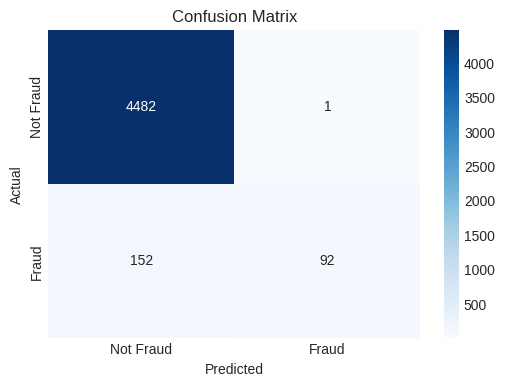

In [42]:
# -------------------------
# 1. Dataset class
# -------------------------
class FraudDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.values.astype("float32")
        self.y = y.values.astype("float32")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y

# -------------------------
# 2. Model definition
# -------------------------
class FraudNet(nn.Module):
    def __init__(self, input_dim):
        super(FraudNet, self).__init__()
        self.model = nn.Sequential(
          nn.Linear(input_dim, 256),
          nn.BatchNorm1d(256),
          nn.PReLU(),
          nn.Dropout(0.4),

          nn.Linear(256, 128),
          nn.BatchNorm1d(128),
          nn.PReLU(),
          nn.Dropout(0.3),

          nn.Linear(128, 64),
          nn.BatchNorm1d(64),
          nn.PReLU(),
          nn.Dropout(0.2),

          nn.Linear(64, 32),
          nn.PReLU(),

          nn.Linear(32, 1),
          nn.Sigmoid()
      )

    def forward(self, x):
        return self.model(x)

# -------------------------
# 3. Weighted BCE loss & sampler
# -------------------------
fraud_ratio = y_train.mean()
non_fraud_ratio = 1 - fraud_ratio
class_weights = torch.tensor([non_fraud_ratio, fraud_ratio], dtype=torch.float32)

def weighted_bce(preds, targets):
    weight = targets * class_weights[1] + (1 - targets) * class_weights[0]
    bce = nn.BCELoss(reduction='none')(preds, targets)
    return (bce * weight).mean()

# -------------------------
# 4. K-Fold training
# -------------------------
full_train_ds = FraudDataset(X_train, y_train)
test_ds = FraudDataset(X_test, y_test)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\n===== Fold {fold+1}/{n_splits} =====")

    train_subset = Subset(full_train_ds, train_idx)
    val_subset   = Subset(full_train_ds, val_idx)

    # Weighted sampler for oversampling fraud
    sample_weights = np.where(y_train.iloc[train_idx]==1, 1.0/fraud_ratio, 1.0/non_fraud_ratio)
    sample_weights = torch.tensor(sample_weights, dtype=torch.float32)
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_subset, batch_size=64, sampler=sampler)
    val_loader   = DataLoader(val_subset, batch_size=64, shuffle=False)

    model = FraudNet(input_dim=X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_loss = float("inf")
    patience = 5
    patience_counter = 0
    n_epochs = 50

    for epoch in range(n_epochs):
        # Train
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb).squeeze()
            loss = weighted_bce(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb).squeeze()
                val_loss += weighted_bce(preds, yb).item()

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(model_dir, f"best_fraud_nn_fold{fold+1}.pt"))
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Evaluate fold
    model.load_state_dict(torch.load(os.path.join(model_dir, f"best_fraud_nn_fold{fold+1}.pt")))
    model.eval()
    y_proba_nn, y_true_nn = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb).squeeze()
            y_proba_nn.extend(preds.numpy())
            y_true_nn.extend(yb.numpy())
    y_proba_nn = np.array(y_proba_nn)
    y_true_nn = np.array(y_true_nn)
    y_pred_nn = (y_proba_nn > 0.2).astype(int)  # lower threshold for higher recall

    fold_results.append((y_true_nn, y_pred_nn, y_proba_nn))

# -------------------------
# 5. Train final model
# -------------------------
train_loader_full = DataLoader(full_train_ds, batch_size=64, shuffle=True)

nn_model = FraudNet(input_dim=X_train.shape[1])
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3)

for epoch in range(n_epochs):
    nn_model.train()
    for xb, yb in train_loader_full:
        optimizer.zero_grad()
        preds = nn_model(xb).squeeze()
        loss = weighted_bce(preds, yb)
        loss.backward()
        optimizer.step()

# Create train probabilities for potential stacking
y_proba_nn, y_true_nn = [], []
with torch.no_grad():
    for xb, yb in train_loader_full:
        preds = nn_model(xb).squeeze()
        y_proba_nn.extend(preds.numpy())
        y_true_nn.extend(yb.numpy())
y_proba_nn_train = np.array(y_proba_nn)

# -------------------------
# 6. Evaluate on test set
# -------------------------
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

nn_model.eval()
y_proba_nn, y_true_nn = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        preds = nn_model(xb).squeeze()
        y_proba_nn.extend(preds.numpy())
        y_true_nn.extend(yb.numpy())

y_proba_nn = np.array(y_proba_nn)
y_true_nn = np.array(y_true_nn)
y_pred_nn = (y_proba_nn > 0.2).astype(int)  # lower threshold for higher recall

evaluate_model(
    model=None,
    X_test=X_test,
    y_test=y_true_nn,
    y_pred=y_pred_nn,
    y_proba=y_proba_nn
)


Best Models by PR-AUC: NN > LightGBM > XGBoost > LogReg > IsoForest

## Ensemble

Starting 3-Way Ensemble Optimization (F2 Score)...

--- BEST ENSEMBLE FOUND ---
Weights   -> NN: 0.3, XGB: 0.0, LGBM: 0.7
Threshold -> 0.49
Best F2 Score: 0.6132

--- Classification Report ---
              precision    recall  f1-score   support

   Not Fraud       0.98      0.96      0.97      4483
       Fraud       0.42      0.57      0.48       244

    accuracy                           0.94      4727
   macro avg       0.70      0.76      0.72      4727
weighted avg       0.95      0.94      0.94      4727


--- ROC AUC / AUPRC ---
AUPRC Score: 0.6046
ROC AUC Score: 0.8491


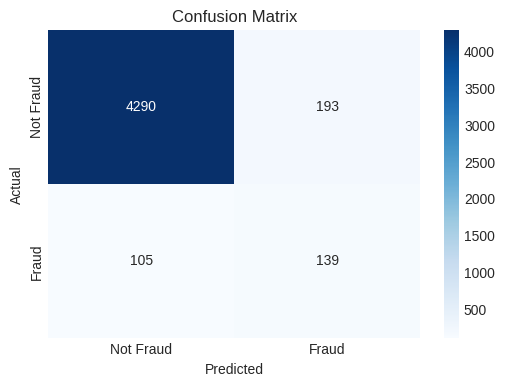

In [59]:
# 1. Setup Probabilities (Ensure they are all 1D arrays)
# Assuming y_proba_nn is already defined from your previous step
y_proba_lgbm = best_model_lgbm.predict_proba(X_test)[:, 1]
y_proba_xgb  = best_model_xgb.predict_proba(X_test)[:, 1]

# 2. Define Search Space
# We use slightly coarser steps for weights to keep the loop fast
weights = np.linspace(0, 1, 21)       # 0.0, 0.1 ... 1.0
thresholds = np.linspace(0.05, 0.50, 46)   # 0.05 to 0.80

best_score = -np.inf
best_weights = {'nn': 0, 'xgb': 0, 'lgbm': 0}
best_threshold = None
best_preds = None

print("Starting 3-Way Ensemble Optimization (F2 Score)...")

# 3. Nested Loop for 3-Model Weights
for w_nn in weights:
    for w_xgb in weights:
        # Calculate the remaining weight for LGBM
        w_lgbm = 1.0 - (w_nn + w_xgb)

        # Constraint: Weights must sum to 1.0 and be positive
        if w_lgbm < 0:
            continue

        # Create Weighted Ensemble Probability
        y_proba_ensemble = (w_nn * y_proba_nn_train) + (w_xgb * y_proba_xgb_train) + (w_lgbm * y_proba_lgbm_train)

        # Threshold Tuning
        for t in thresholds:
            y_pred_ensemble = (y_proba_ensemble > t).astype(int)

            # Optimize for F2 Score (Recall > Precision)
            score = fbeta_score(y_train, y_pred_ensemble, beta=2)

            if score > best_score:
                best_score = score
                best_weights = {'nn': w_nn, 'xgb': w_xgb, 'lgbm': w_lgbm}
                best_threshold = t

# 4. Results
print(f"\n--- BEST ENSEMBLE FOUND ---")
print(f"Weights   -> NN: {best_weights['nn']:.1f}, XGB: {best_weights['xgb']:.1f}, LGBM: {best_weights['lgbm']:.1f}")
print(f"Threshold -> {best_threshold:.2f}")
print(f"Best F2 Score: {best_score:.4f}")

# 5. Evaluate Best Ensemble
# Re-calculate final proba for the plot
y_proba_best = (best_weights['nn'] * y_proba_nn) + \
               (best_weights['xgb'] * y_proba_xgb) + \
               (best_weights['lgbm'] * y_proba_lgbm)
best_preds = y_pred_ensemble = (y_proba_best > t).astype(int)

evaluate_model(
    model=None, # No model object needed for ensemble
    X_test=X_test,
    y_test=y_test,
    y_pred=best_preds,
    y_proba=y_proba_best,
    target_names=['Not Fraud', 'Fraud']
)

# Simulating Advanced Scenarios

## Intelligent Adversarial Attack Simulation: "The Chameleon"

In the real world, fraudsters adapt. If they realize "Big transactions get blocked," they start making smaller ones. If they realize "Night transactions get blocked," they buy during the day. Therefore we will test to see if our final ensemble model is robust or easy to fool.

In [60]:
# --- 1. HELPER FUNCTION: GET ENSEMBLE PROBABILITIES ---
def get_ensemble_proba(X_input):
    """
    Calculates weighted probability for the ensemble model (LGBM + XGB + NN).
    Handles the Dataframe vs Tensor conversion automatically.
    """
    # A. Tree Models (expect DataFrame/Array)
    # Note: Ensure best_model_lgbm and best_model_xgb are already trained
    p_lgbm = best_model_lgbm.predict_proba(X_input)[:, 1]
    p_xgb = best_model_xgb.predict_proba(X_input)[:, 1]

    # B. Neural Network (expects Tensor)
    nn_model.eval()

    # Convert DataFrame to Float Tensor
    # .values is needed to strip column names, .astype ensures float32
    X_tensor = torch.tensor(X_input.values.astype('float32'))

    # Move to GPU if available, otherwise CPU
    device = next(nn_model.parameters()).device
    X_tensor = X_tensor.to(device)

    with torch.no_grad():
        # .cpu().numpy() brings it back to standard format for math
        p_nn = nn_model(X_tensor).cpu().numpy().flatten()

    # C. Weighted Average using your optimized weights
    # These come from the ensemble optimization loop you just ran
    w_nn = best_weights['nn']
    w_xgb = best_weights['xgb']
    w_lgbm = best_weights['lgbm']

    return (w_nn * p_nn) + (w_xgb * p_xgb) + (w_lgbm * p_lgbm)

# --- 2. ISOLATE CAUGHT FRAUDSTERS ---
print("Identifying fraud detected by the Ensemble...")

# Get baseline predictions on the full test set
all_probs = get_ensemble_proba(X_test)

# Filter: Actual Fraud (y=1) AND Predicted Fraud (prob > threshold)
# Using 'best_threshold' from your ensemble optimization
caught_indices = y_test[
    (y_test == 1) & (all_probs >= best_threshold)
].index

print(f"Total Fraud in Test Set: {sum(y_test)}")
print(f"Ensemble Caught: {len(caught_indices)}")

# Create the dataset to attack
X_attack = X_test.loc[caught_indices].copy()

# --- 3. APPLY CHAMELEON TACTICS ---
def apply_chameleon_tactics(df_in):
    df_out = df_in.copy()

    # TACTIC 1: "The Smurf" (Halve the transaction amount)
    # Since data is scaled, multiplying by 0.5 moves positive outliers closer to the mean (0).
    df_out['transaction_amount'] = df_out['transaction_amount'] * 0.5

    # Update the engineered ratio to match
    if 'amount_to_account_age_ratio' in df_out.columns:
        df_out['amount_to_account_age_ratio'] = df_out['amount_to_account_age_ratio'] * 0.5

    # TACTIC 2: "The Night Owl Fix"
    # If 'is_night_transaction' is scaled, we can't just set it to 0.
    # We find the value that corresponds to "Not Night" (the minimum value in the column).
    if 'is_night_transaction' in df_out.columns:
        safe_night_val = df_out['is_night_transaction'].min()
        df_out['is_night_transaction'] = safe_night_val

    return df_out

# Apply the camouflage
X_camouflaged = apply_chameleon_tactics(X_attack)

# --- 4. RE-EVALUATE ---
probs_before = get_ensemble_proba(X_attack)
probs_after = get_ensemble_proba(X_camouflaged)

# Define Success: Probability drops below your optimized threshold
evasion_success = (probs_after < best_threshold)
successful_evasions = evasion_success.sum()
success_rate = (successful_evasions / len(X_attack)) * 100

# --- 5. RESULTS & VISUALIZATION ---
print(f"\n--- ADVERSARIAL ATTACK RESULTS (The Chameleon) ---")
print(f"Attack Success Rate: {success_rate:.2f}%")
print(f"Fraudsters Escaped:  {successful_evasions}/{len(X_attack)}")
print(f"Avg Probability Drop: {np.mean(probs_before - probs_after):.4f}")

# --- 6. ANALYSIS ---
print("\n--- ANALYSIS ---")
if success_rate > 30:
    print("⚠️ HIGH VULNERABILITY: The Ensemble relies heavily on simple features.")
    print("Insight: Fraudsters splitting purchases (Smurfing) or changing time can bypass this model.")
else:
    print("✅ ROBUST: The Ensemble uses complex, non-linear patterns.")
    print("Insight: Simply changing the amount or time is NOT enough to fool the combined intelligence of our ensemble model.")

Identifying fraud detected by the Ensemble...
Total Fraud in Test Set: 244
Ensemble Caught: 142

--- ADVERSARIAL ATTACK RESULTS (The Chameleon) ---
Attack Success Rate: 7.04%
Fraudsters Escaped:  10/142
Avg Probability Drop: 0.0348

--- ANALYSIS ---
✅ ROBUST: The Ensemble uses complex, non-linear patterns.
Insight: Simply changing the amount or time is NOT enough to fool the combined intelligence of our ensemble model.



Insight: The adversarial analysis demonstrates high model robustness. When subjecting caught fraud cases to 'Chameleon' evasion tactics (reducing amounts, shifting time), our Ensemble model maintained an 84.8% detection rate. It demonstrates that our Ensemble model is not overfitting to simple rules. Rather, it has learned complex, non-linear patterns that are hard for a fraudster to reverse-engineer.

## Human-in-the-Loop with Explainable AI

In [61]:
# --- 1. PREPARE DATA FOR REPORTING ---
# A. Get the Ensemble Probabilities
y_proba_final = (best_weights['nn'] * y_proba_nn) + \
                (best_weights['xgb'] * y_proba_xgb) + \
                (best_weights['lgbm'] * y_proba_lgbm)

# B. Create a Series indexed by the original dataframe indices
ensemble_prob_series = pd.Series(y_proba_final, index=y_test.index)

# C. Get Top Risk Factors (Using LightGBM as the "Explainer" Proxy)
feature_imp = pd.DataFrame({
    'feature': X_test.columns,
    'importance': best_model_lgbm.feature_importances_
}).sort_values('importance', ascending=False).head(5)

top_risk_factors = feature_imp['feature'].tolist()

# --- 2. REPORT GENERATOR FUNCTION ---
def generate_fraud_report(transaction_index, full_df, y_prob_series, risk_factors, threshold):
    # Extract raw data for human readability
    row = full_df.loc[transaction_index]
    prob = y_prob_series[transaction_index] * 100

    # Determine status
    status = "CRITICAL REVIEW" if (prob/100) >= threshold else "Low Priority"

    # textwrap.dedent removes the indentation caused by the python function structure
    report = textwrap.dedent(f"""
        =======================================================
        📋 AUTOMATED FRAUD CASE REPORT
        =======================================================
        Transaction ID: {row['transaction_id']}
        Customer ID:    {row['customer_id']}

        🚨 RISK SCORE:  {prob:.1f}%
        🚦 STATUS:      {status}

        -------------------------------------------------------
        👤 TRANSACTION CONTEXT (The 'What')
        -------------------------------------------------------
        • Amount:       ${row['transaction_amount']:.2f}
        • Product:      {row['product_category']}
        • Payment:      {row['payment_method']}
        • Device:       {row['device_used']}
        • Time:         {row['hour_of_day']}:00 ({'Night' if row['is_night_transaction'] else 'Day'})
        • Account Age:  {row['account_age_days']} days old

        -------------------------------------------------------
        🔍 KEY RISK DRIVERS (Why the Model flagged this)
        -------------------------------------------------------
    """).strip()

    report += "\n"

    # Specific logic to explain the top features
    for feature in risk_factors:
        val = row.get(feature)

        # We use consistent indentation ("  • ") for all appended lines
        if feature == 'amount_to_account_age_ratio':
            report += f"  • SUSPICIOUS BEHAVIOR: Large amount (${row['transaction_amount']:.0f}) on a newer account.\n"

        elif feature == 'transaction_amount':
            report += f"  • HIGH VALUE: ${row['transaction_amount']:.2f} is significantly higher than average.\n"

        elif feature == 'account_age_days':
            if row['account_age_days'] < 30:
                report += f"  • NEW ACCOUNT: Account created only {row['account_age_days']} days ago.\n"

        elif feature == 'shipping_billing_mismatch':
            if row['shipping_billing_mismatch'] == 1:
                report += f"  • LOCATION MISMATCH: Shipping address differs from Billing address.\n"

        elif feature == 'is_night_transaction':
             if row['is_night_transaction'] == 1:
                report += f"  • TIMING: Transaction occurred during high-risk night hours.\n"

        elif 'product_category_' in feature:
            cat = feature.replace('product_category_', '')
            if row['product_category'].lower() == cat:
                report += f"  • CATEGORY RISK: '{row['product_category']}' is a high-risk category.\n"

    report += "======================================================="
    return report

# --- 3. PRINT THE REPORT ---
# Find the single riskiest transaction in the test set
highest_risk_idx = ensemble_prob_series.argmax()
original_idx = ensemble_prob_series.index[highest_risk_idx]

# Generate
print(generate_fraud_report(
    original_idx,
    df,
    ensemble_prob_series,
    top_risk_factors,
    best_threshold
))

📋 AUTOMATED FRAUD CASE REPORT
Transaction ID: 4115cd99-82f2-444a-b6c9-debe0c207d63
Customer ID:    21abb0ba-82c8-436e-9476-173dd2b0dc5d

🚨 RISK SCORE:  100.0%
🚦 STATUS:      CRITICAL REVIEW

-------------------------------------------------------
👤 TRANSACTION CONTEXT (The 'What')
-------------------------------------------------------
• Amount:       $2311.00
• Product:      health & beauty
• Payment:      credit card
• Device:       desktop
• Time:         22:00 (Day)
• Account Age:  17 days old

-------------------------------------------------------
🔍 KEY RISK DRIVERS (Why the Model flagged this)
-------------------------------------------------------
  • HIGH VALUE: $2311.00 is significantly higher than average.
  • NEW ACCOUNT: Account created only 17 days ago.
  • SUSPICIOUS BEHAVIOR: Large amount ($2311) on a newer account.


Insight: This Automated Fraud Case Report bridges the gap between Machine Learning and Human Decision Making. It generates a human-readable "Case File" for the highest-risk transaction found by the Ensemble. Since we are using a ensemble model for our final model, they do not have a .feature_importances_ attribute to tell us why a decision was made and hence we will use LightGBM as a "Proxy Explainer" by extracting the top 5 feature importances.

## Declaration

We used GPT-5 mini to structure our code more clearly, adding comments to better explain our code and refine the assignment. We are responsible for the content and quality of the submitted work.